### Célula 00: Execução Final do Simulador de Atendimento e Geração de Dados de Treinamento

Esta célula é a **execução principal** e o ápice de todo o código de simulação. Ela inicia o *script* interativo, permitindo que o usuário simule um ciclo completo de atendimento de cobrança.

* **Objetivo:**
    1.  Interagir com o usuário, solicitando dados de um novo cliente (BAN, nome, dívidas, etc.).
    2.  Executar o fluxo completo do **`AtendimentoClaro`**, que inclui as etapas de abertura, negociação, oferta de Débito Automático (DCC) e encerramento.
    3.  **Gerar Dados de Treinamento:** O ponto mais importante é que, durante a execução, as interações do atendente (como a geração de boletos pelo **TOTEM** e o registro de ações no **PS8**) são salvas automaticamente em arquivos CSV.

* **Três Saídas de Dados (Futuras *Features* de ML):**
    * **SAAS (`saas_clientes.csv`):** Armazena o perfil básico dos clientes (dados cadastrais).
    * **PS8 (`ps8_registros.csv`):** Contém os **resultados** das negociações (pagamento à vista, parcelamento, pendente), que são cruciais para treinar modelos futuros de **Propensão de Pagamento**.
    * **TOTEM (`totem_boletos.csv`):** Registra os boletos emitidos (o valor e a data de vencimento), essenciais para rastrear a recuperação da dívida.

* **Fluxo Interativo:** O *script* exige que o usuário insira os dados do cliente e **tome decisões** durante a negociação (ex: Pagamento à vista, Parcelamento, etc.), replicando a experiência de um operador de *call center*.


In [ ]:
# %% [markdown]
# # 🎯 Simulador de Atendimento de Cobrança - Claro
#
# Este simulador reproduz o ambiente real de trabalho em um call center de cobrança, integrando:
# - **SAAS**: Discador com dados básicos dos clientes
# - **PS8**: Sistema de registro de atendimentos
# - **TOTEM**: Geração de boletos
#
# Todos os dados são salvos automaticamente em arquivos CSV para uso posterior nas análises de Machine Learning.
# %%
import pandas as pd
import numpy as np
import time
import datetime
from datetime import date
import os
from google.colab import files
from faker import Faker
# Criar diretório para os dados se não existir
os.makedirs('/content/dados_simulados', exist_ok=True)
# Caminhos dos arquivos CSV
SAAS_FILE = '/content/dados_simulados/saas_clientes.csv'
PS8_FILE = '/content/dados_simulados/ps8_registros.csv'
TOTEM_FILE = '/content/dados_simulados/totem_boletos.csv'
# %% [markdown]
# ## 🏢 Classe para Simulação do SAAS (Discador)
# %%
class SistemaSAAS:
    def __init__(self, arquivo_saas=SAAS_FILE):
        self.arquivo_saas = arquivo_saas
        self.clientes = self.carregar_clientes()

    def carregar_clientes(self):
        """Carrega clientes do arquivo CSV ou cria dados iniciais"""
        try:
            df = pd.read_csv(self.arquivo_saas)
            print(f"✅ Dados SAAS carregados: {len(df)} clientes")
            return df.to_dict('records')
        except FileNotFoundError:
            print("📝 Arquivo SAAS não encontrado. Iniciando com lista vazia.")
            return []

    def salvar_clientes(self):
        """Salva clientes no arquivo CSV"""
        if self.clientes:
            df = pd.DataFrame(self.clientes)
            df.to_csv(self.arquivo_saas, index=False)
            print(f"💾 SAAS salvo: {len(self.clientes)} clientes")

    def buscar_cliente_por_ban(self, ban):
        """Busca cliente pelo número BAN"""
        for cliente in self.clientes:
            if str(cliente.get('ban')) == str(ban):
                return cliente
        return None

    def adicionar_cliente(self, cliente):
        """Adiciona novo cliente ao SAAS"""
        if not self.buscar_cliente_por_ban(cliente['ban']):
            self.clientes.append(cliente)
            self.salvar_clientes()
            print(f"✅ Cliente {cliente['nome']} adicionado ao SAAS")
            return True
        else:
            print("⚠️ Cliente já existe no SAAS")
            return False
# %% [markdown]
# ## 📋 Classe para Simulação do PS8 (Registro de Atendimentos)
# %%
class SistemaPS8:
    def __init__(self, arquivo_ps8=PS8_FILE):
        self.arquivo_ps8 = arquivo_ps8
        self.registros = self.carregar_registros()

    def carregar_registros(self):
        """Carrega registros do arquivo CSV"""
        try:
            df = pd.read_csv(self.arquivo_ps8)
            print(f"✅ Dados PS8 carregados: {len(df)} registros")
            return df.to_dict('records')
        except FileNotFoundError:
            print("📝 Arquivo PS8 não encontrado. Iniciando com lista vazia.")
            return []

    def salvar_registros(self):
        """Salva registros no arquivo CSV"""
        if self.registros:
            df = pd.DataFrame(self.registros)
            df.to_csv(self.arquivo_ps8, index=False)
            print(f"💾 PS8 salvo: {len(self.registros)} registros")

    def adicionar_registro(self, registro):
        """Adiciona novo registro de atendimento"""
        # Gerar ID automático
        if self.registros:
            ultimo_id = max([r.get('id_registro', 0) for r in self.registros])
            novo_id = ultimo_id + 1
        else:
            novo_id = 1

        registro_completo = {
            'id_registro': novo_id,
            'data_atendimento': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            **registro
        }

        self.registros.append(registro_completo)
        self.salvar_registros()
        print(f"✅ Registro PS8 adicionado: {registro_completo['resultado']}")
        return registro_completo
# %% [markdown]
# ## 🧾 Classe para Simulação do TOTEM (Geração de Boletos)
# %%
class SistemaTOTEM:
    def __init__(self, arquivo_totem=TOTEM_FILE):
        self.arquivo_totem = arquivo_totem
        self.boletos = self.carregar_boletos()

    def carregar_boletos(self):
        """Carrega boletos do arquivo CSV"""
        try:
            df = pd.read_csv(self.arquivo_totem)
            print(f"✅ Dados TOTEM carregados: {len(df)} boletos")
            return df.to_dict('records')
        except FileNotFoundError:
            print("📝 Arquivo TOTEM não encontrado. Iniciando com lista vazia.")
            return []

    def salvar_boletos(self):
        """Salva boletos no arquivo CSV"""
        if self.boletos:
            df = pd.DataFrame(self.boletos)
            df.to_csv(self.arquivo_totem, index=False)
            print(f"💾 TOTEM salvo: {len(self.boletos)} boletos")

    def gerar_boleto(self, ban, valor, dias_vencimento=5):
        """Gera novo boleto"""
        # Gerar ID automático
        if self.boletos:
            ultimo_id = max([b.get('id_boleto', 0) for b in self.boletos])
            novo_id = ultimo_id + 1
        else:
            novo_id = 1

        # Gerar código de barras simulado
        codigo_barras = ''.join([str(np.random.randint(0, 9)) for _ in range(44)])

        novo_boleto = {
            'id_boleto': novo_id,
            'ban': str(ban),
            'valor': float(valor),
            'data_emissao': date.today().strftime("%Y-%m-%d"),
            'data_vencimento': (date.today() + datetime.timedelta(days=dias_vencimento)).strftime("%Y-%m-%d"),
            'codigo_barras': codigo_barras,
            'status': 'emitido'
        }

        self.boletos.append(novo_boleto)
        self.salvar_boletos()
        print(f"✅ Boleto gerado: R$ {valor:.2f} - Vencimento: {novo_boleto['data_vencimento']}")
        return novo_boleto
# %% [markdown]
# ## ✅ Classe para o Checklist Interativo
# %%
class Checklist:
    def __init__(self):
        self.itens = {
            1: {"descricao": "Confirmar nome completo ou CPF.", "concluido": False},
            2: {"descricao": "Informar atraso e valor.", "concluido": False},
            3: {"descricao": "Valorizar desconto e priorizar pagamento imediato.", "concluido": False},
            4: {"descricao": "Confirmar telefone e email.", "concluido": False},
            5: {"descricao": "Ofertar Débito Automático (DCC).", "concluido": False},
            6: {"descricao": "Informar prazo de religação (72h após pagamento).", "concluido": False},
            7: {"descricao": "Pesquisa de inadimplência.", "concluido": False},
            8: {"descricao": "Informar ações de cobrança (juros, multas, etc).", "concluido": False},
            9: {"descricao": "Repassar o acordo (confirmar data e valor).", "concluido": False},
            10: {"descricao": "Perguntar se o cliente tem dúvidas.", "concluido": False}
        }
    def marcar_concluido(self, numero_item):
        if numero_item in self.itens:
            self.itens[numero_item]["concluido"] = True
    def exibir_status(self):
        print("\n✅ CHECKLIST DO ATENDIMENTO - STATUS")
        for num, item in self.itens.items():
            status = "✅ CONCLUÍDO" if item["concluido"] else "❌ PENDENTE"
            print(f"{status}: {num}. {item['descricao']}")
        print("\n---")
# %% [markdown]
# ## 💰 Classe de Negociação do Cliente (Adaptada)
# %%
class NegociacaoCliente:
    def __init__(self, cliente, ps8, totem):
        """
        Inicializa a classe de negociação com dados do cliente.
        """
        self.nome_cliente = cliente['nome']
        self.ban_cliente = cliente['ban']
        self.faturas = cliente['faturas']
        self.faturas_atrasadas = len(self.faturas)
        self.valor_total_divida = sum(fatura['valor'] for fatura in self.faturas)
        self.ps8 = ps8
        self.totem = totem

        self.script_negociacao = {
            "saudacao": f"Olá, {self.nome_cliente}. Meu nome é Cláudia, e estou falando da Claro. O motivo do meu contato é sobre as faturas em atraso do seu serviço.",
            "confirmacao_total": f"Para confirmar, posso falar sobre o pagamento das {self.faturas_atrasadas} faturas vencidas, que totalizam R$ {self.valor_total_divida:.2f}?",
            "opcoes_pagamento": {
                "a_vista": "1. Pagamento à vista (cartão ou boleto)",
                "parcelamento": "2. Parcelamento com entrada",
                "outro": "3. Outra condição/prazo"
            }
        }
    def iniciar_negociacao(self):
        """
        Simula a negociação com o cliente.
        """
        print("--- Negociação Iniciada ---")
        print(self.script_negociacao["saudacao"])
        time.sleep(1)
        print(self.script_negociacao["confirmacao_total"])

        input("\nPressione Enter para simular a resposta do cliente...\n")
        print("Atendente: Vamos às opções de pagamento.")

        return self.negociar_pagamento(self.faturas)

    def negociar_pagamento(self, faturas_para_negociar):
        """
        Lógica central de negociação com opções de pagamento.
        """
        valor_negociacao = sum(fatura['valor'] for fatura in faturas_para_negociar)
        num_faturas = len(faturas_para_negociar)

        print(f"\n--- Negociação de {num_faturas} Fatura(s) - Total: R$ {valor_negociacao:.2f} ---")
        print("Opções disponíveis:")
        for key, value in self.script_negociacao["opcoes_pagamento"].items():
            print(f"  {value}")

        resposta = input("\nEscolha a opção (1/2/3): ").strip()

        if resposta == "1":
            # Pagamento à vista
            boleto = self.totem.gerar_boleto(self.ban_cliente, valor_negociacao)
            registro = {
                'ban': self.ban_cliente,
                'tipo_atendimento': 'cobrança',
                'resultado': 'pagamento_avista',
                'valor_negociado': valor_negociacao,
                'metodo_pagamento': 'boleto',
                'observacoes': 'Cliente optou por pagamento à vista via boleto'
            }
            self.ps8.adicionar_registro(registro)
            return {"resultado": "pagamento_avista", "valor": valor_negociacao}

        elif resposta == "2":
            # Parcelamento
            entrada = max(25.0, float(input("Valor da entrada (mínimo R$ 25,00): R$ ")))
            parcelas = int(input("Número de parcelas: "))

            boleto_entrada = self.totem.gerar_boleto(self.ban_cliente, entrada, 3)
            registro = {
                'ban': self.ban_cliente,
                'tipo_atendimento': 'cobrança',
                'resultado': 'parcelamento',
                'valor_negociado': valor_negociacao,
                'metodo_pagamento': 'parcelado',
                'observacoes': f'Parcelamento em {parcelas}x com entrada de R$ {entrada:.2f}'
            }
            self.ps8.adicionar_registro(registro)
            return {"resultado": "parcelamento", "entrada": entrada, "parcelas": parcelas}

        else:
            # Outra situação
            registro = {
                'ban': self.ban_cliente,
                'tipo_atendimento': 'cobrança',
                'resultado': 'negociacao_pendente',
                'valor_negociado': 0,
                'metodo_pagamento': 'nenhum',
                'observacoes': 'Cliente não aceitou nenhuma opção de pagamento'
            }
            self.ps8.adicionar_registro(registro)
            return {"resultado": "negociacao_pendente"}
# %% [markdown]
# ## 📞 Classe Principal de Atendimento (Adaptada)
# %%
class AtendimentoClaro:
    def __init__(self, cliente):
        self.cliente = cliente
        self.saas = SistemaSAAS()
        self.ps8 = SistemaPS8()
        self.totem = SistemaTOTEM()
        self.checklist = Checklist()

        # Adicionar cliente ao SAAS se não existir
        if not self.saas.buscar_cliente_por_ban(cliente['ban']):
            cliente_saas = {
                'ban': cliente['ban'],
                'nome': cliente['nome'],
                'cpf': cliente['cpf'],
                'telefone': cliente['telefone'],
                'email': cliente['email'],
                'produto': cliente['produto'],
                'status': 'ativo'
            }
            self.saas.adicionar_cliente(cliente_saas)

        self.negociacao = NegociacaoCliente(cliente, self.ps8, self.totem)
    def abertura_atendimento(self):
        """Etapa 1: Abertura e verificação inicial."""
        print("📞 ETAPA 1 - ABERTURA DO ATENDIMENTO")
        print(f"\n[FALA AO CLIENTE] Bom dia! Falo com o(a) Sr(a). {self.cliente['nome']}?")
        print("Meu nome é Cláudia, falo em nome da Claro.")
        print("Para confirmar, poderia me informar seu nome completo ou CPF?")

        input("\nPressione Enter para simular a confirmação do cliente...")
        self.checklist.marcar_concluido(1)

        print("\n[FALA AO CLIENTE] Por favor, aguarde um momento enquanto consulto seus dados...")
        time.sleep(2)

        print(f"\n[AÇÃO NO SISTEMA] Cliente identificado: {self.cliente['nome']}")
        print(f"BAN: {self.cliente['ban']} | CPF: {self.cliente['cpf']}")
        print(f"Faturas em atraso: {len(self.cliente['faturas'])}")
        print(f"Valor total: R$ {self.negociacao.valor_total_divida:.2f}")
    def iniciar_negociacao(self):
        """Etapa 2: Negociação e identificação do motivo."""
        print("\n" + "="*50)
        print("📞 ETAPA 2 - INÍCIO DA NEGOCIAÇÃO")
        print("="*50)

        print(f"\n[FALA AO CLIENTE] Sr(a). {self.cliente['nome']}, estou entrando em contato")
        print(f"referente às {len(self.cliente['faturas'])} faturas em atraso,")
        print(f"totalizando R$ {self.negociacao.valor_total_divida:.2f}.")

        self.checklist.marcar_concluido(2)

        motivo = input("\n[AÇÃO] Motivo do atraso (digite breve descrição): ")
        self.checklist.marcar_concluido(7)

        print("[FALA AO CLIENTE] Entendo sua situação. Vamos encontrar a melhor solução.")

        # Iniciar negociação
        resultado = self.negociacao.iniciar_negociacao()
        self.checklist.marcar_concluido(3)
        self.checklist.marcar_concluido(4)
        self.checklist.marcar_concluido(9)

        return resultado
    def oferecer_dcc(self):
        """Oferta do Débito Automático"""
        print("\n" + "="*50)
        print("📞 ETAPA 3 - OFERTA DE DÉBITO AUTOMÁTICO")
        print("="*50)

        print("\n[FALA AO CLIENTE] Sr(a). {self.cliente['nome']}, a Claro oferece")
        print("débito automático com desconto de R$ 5,00 em todas as faturas.")
        print("Gostaria de conhecer melhor essa opção?")

        resposta = input("\n[AÇÃO] Cliente interessado? (s/n): ").lower()

        if resposta == 's':
            print("\n[FALA AO CLIENTE] Excelente! O débito automático é seguro")
            print("e evita esquecimentos. Posso enviar mais informações?")
            self.checklist.marcar_concluido(5)
        else:
            print("\n[FALA AO CLIENTE] Sem problemas. Continuando com nosso atendimento...")
    def encerrar_atendimento(self):
        """Etapa final do atendimento"""
        print("\n" + "="*50)
        print("📞 ETAPA FINAL - ENCERRAMENTO")
        print("="*50)

        print("\n[FALA AO CLIENTE] Para evitar bloqueios e negativação do seu CPF,")
        print("recomendo que regularize sua situação o mais breve possível.")

        self.checklist.marcar_concluido(8)

        duvidas = input("\n[AÇÃO] Cliente tem dúvidas? (s/n): ").lower()
        if duvidas == 'n':
            self.checklist.marcar_concluido(10)

        print("\n[FALA AO CLIENTE] Obrigada pelo contato. Tenha um ótimo dia!")
        print("Qualquer dúvida, estamos à disposição.")
    def registrar_ps8(self):
        """Registro final no PS8"""
        print("\n" + "="*50)
        print("💻 ETAPA - REGISTRO NO PS8")
        print("="*50)

        print("\n[AÇÃO NO PS8] Registrando atendimento...")
        time.sleep(1)

        registro_final = {
            'ban': self.cliente['ban'],
            'tipo_atendimento': 'cobrança',
            'resultado': 'atendimento_concluido',
            'valor_negociado': self.negociacao.valor_total_divida,
            'metodo_pagamento': 'informar_nos_sistemas',
            'observacoes': 'Atendimento de cobrança concluído com sucesso'
        }

        self.ps8.adicionar_registro(registro_final)
        print("✅ Registro PS8 concluído")
    def executar_atendimento(self):
        """Executa o fluxo completo do atendimento"""
        try:
            self.abertura_atendimento()
            self.iniciar_negociacao()
            self.oferecer_dcc()
            self.encerrar_atendimento()
            self.registrar_ps8()

            # Mostrar checklist final
            print("\n" + "="*50)
            print("✅ CHECKLIST FINAL")
            print("="*50)
            self.checklist.exibir_status()

            print("\n🎉 ATENDIMENTO CONCLUÍDO COM SUCESSO!")
            print("💾 Dados salvos nos sistemas SAAS, PS8 e TOTEM")

        except Exception as e:
            print(f"❌ Erro durante o atendimento: {e}")
# %% [markdown]
# ## 📋 Funções Auxiliares
# %%
def parse_faturas(faturas_input):
    """
    Converte texto de faturas para lista de dicionários.
    Formato: "DATA R$ VALOR"
    Exemplo: "01/01/2024 R$ 99,90"
    """
    faturas = []
    for linha in faturas_input.strip().split('\n'):
        if 'R$' in linha:
            partes = linha.split('R$')
            if len(partes) == 2:
                data = partes[0].strip()
                valor_str = partes[1].strip().replace(',', '.')
                try:
                    valor = float(valor_str)
                    faturas.append({'vencimento': data, 'valor': valor})
                except ValueError:
                    print(f"⚠️ Valor inválido: {valor_str}")
    return faturas
def carregar_dados_exemplo():
    """Carrega dados de exemplo se os arquivos estiverem vazios"""
    saas = SistemaSAAS()
    ps8 = SistemaPS8()
    totem = SistemaTOTEM()

    # Adicionar exemplo se não houver dados
    if not saas.clientes:
        cliente_exemplo = {
            'ban': '100000001',
            'nome': 'João Silva',
            'cpf': '123.456.789-00',
            'telefone': '(11) 99999-9999',
            'email': 'joao.silva@email.com',
            'produto': 'CLARO NET VIRTUA',
            'status': 'ativo'
        }
        saas.adicionar_cliente(cliente_exemplo)

    if not ps8.registros:
        registro_exemplo = {
            'ban': '100000001',
            'tipo_atendimento': 'cobrança',
            'resultado': 'exemplo',
            'valor_negociado': 150.0,
            'metodo_pagamento': 'boleto',
            'observacoes': 'Registro de exemplo'
        }
        ps8.adicionar_registro(registro_exemplo)

    if not totem.boletos:
        totem.gerar_boleto('100000001', 150.0)
# %% [markdown]
# ## 🚀 Execução Principal do Simulador
# %%
# Carregar dados de exemplo se necessário
carregar_dados_exemplo()
print("🎯 SIMULADOR DE ATENDIMENTO - CLARO COBRANÇA")
print("="*55)
# Solicitar dados do cliente
print("\n📝 DIGITE OS DADOS DO CLIENTE:")
ban = input("BAN do cliente: ").strip() or "100000002"
nome = input("Nome do cliente: ").strip() or "Maria Santos"
cpf = input("CPF do cliente: ").strip() or "987.654.321-00"
telefone = input("Telefone: ").strip() or "(11) 98888-8888"
email = input("Email: ").strip() or "maria.santos@email.com"
produto = input("Produto: ").strip() or "CLARO FIXO + INTERNET"
# Solicitar faturas
print("\n💳 DIGITE AS FATURAS EM ATRASO (formato: DD/MM/AAAA R$ VALOR)")
print("Exemplo: 01/01/2024 R$ 99,90")
print("Pressione Enter duas vezes para finalizar:")
faturas_input = ""
while True:
    linha = input()
    if not linha:
        break
    faturas_input += linha + "\n"
# Processar faturas
faturas = parse_faturas(faturas_input)
if not faturas:
    print("⚠️ Nenhuma fatura válida. Usando exemplo...")
    faturas = [{'vencimento': '01/01/2024', 'valor': 99.90}]
# Criar cliente
cliente = {
    "ban": ban,
    "nome": nome,
    "cpf": cpf,
    "telefone": telefone,
    "email": email,
    "produto": produto,
    "faturas": faturas
}
# Executar atendimento
print("\n" + "="*55)
print("🚀 INICIANDO ATENDIMENTO")
print("="*55)
atendimento = AtendimentoClaro(cliente)
atendimento.executar_atendimento()
# %% [markdown]
# ## 📊 Visualização dos Dados Gerados
# %%
# Mostrar dados gerados
print("\n" + "="*55)
print("📊 DADOS GERADOS NOS SISTEMAS")
print("="*55)
# SAAS
saas_df = pd.read_csv(SAAS_FILE) if os.path.exists(SAAS_FILE) else pd.DataFrame()
print(f"\n📋 SAAS - Clientes ({len(saas_df)} registros):")
if not saas_df.empty:
    display(saas_df.tail())
else:
    print("Nenhum dado disponível")
# PS8
ps8_df = pd.read_csv(PS8_FILE) if os.path.exists(PS8_FILE) else pd.DataFrame()
print(f"\n📋 PS8 - Registros ({len(ps8_df)} registros):")
if not ps8_df.empty:
    display(ps8_df.tail())
else:
    print("Nenhum dado disponível")
# TOTEM
totem_df = pd.read_csv(TOTEM_FILE) if os.path.exists(TOTEM_FILE) else pd.DataFrame()
print(f"\n📋 TOTEM - Boletos ({len(totem_df)} registros):")
if not totem_df.empty:
    display(totem_df.tail())
else:
    print("Nenhum dado disponível")
# %% [markdown]
# ## 💾 Download dos Arquivos CSV
# %%
# Download dos arquivos CSV
def download_arquivos():
    arquivos = [SAAS_FILE, PS8_FILE, TOTEM_FILE]
    for arquivo in arquivos:
        if os.path.exists(arquivo):
            files.download(arquivo)
            print(f"📥 Download: {arquivo}")
        else:
            print(f"⚠️ Arquivo não encontrado: {arquivo}")
print("💾 DOWNLOAD DOS ARQUIVOS CSV:")
print("Os arquivos contêm todos os dados simulados para uso no projeto de ML")
download_arquivos()

### Célula 0: Configuração do Ambiente e Importação de Bibliotecas Essenciais

Esta célula é o ponto de partida (*bootstrap*) do projeto, estabelecendo a base técnica necessária para todo o pipeline de Machine Learning (ML).

* **Instalação de Dependências:** O comando `!pip install -q` garante que todas as bibliotecas de ponta a ponta sejam instaladas de forma silenciosa e eficiente, incluindo ferramentas para **simulação de dados** (`Faker`), modelos robustos (`xgboost`), técnicas de balanceamento (`imbalanced-learn`) e *Deep Learning* (`tensorflow`, `torch`).

* **Importação Estratégica:** As bibliotecas são importadas de forma modular, agrupadas por função:
    * **Manipulação/Visualização:** `pandas`, `numpy`, `seaborn`.
    * **Pré-processamento:** `TfidfVectorizer`, `LabelEncoder`, `StandardScaler` (elementos cruciais para dados heterogêneos).
    * **Modelagem:** Quatro arquiteturas distintas são preparadas (`RandomForestClassifier`, `SVC`, `XGBClassifier`, `tensorflow.keras`) para um **benchmarking rigoroso**.
    * **Otimização:** `StratifiedKFold` e `class_weight` são importados para lidar com o **desbalanceamento de classes**.


In [ ]:
# # 🎯 Sistema de Priorização de Atendimento com Machine Learning
#
# ## 📋 Contexto do Desafio
# Sistema inteligente para priorização automática de chamados em call center de cobrança, classificando por urgência (Alta, Média, Baixa) usando Machine Learning.

# %%
# 📦 Instalação de dependências
!pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost imbalanced-learn
!pip install -q tensorflow
!pip install -q torch
!pip install -q Faker

# 📚 Importação de bibliotecas
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import os
from google.colab import files
from faker import Faker

# Pré-processamento de texto
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Modelos de ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Métricas e avaliação
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Redes Neurais
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Para salvar modelos
import pickle
from scipy.sparse import hstack

# Configurações
import warnings
warnings.filterwarnings('ignore')

print("✅ Todas as bibliotecas importadas com sucesso!")

✅ Todas as bibliotecas importadas com sucesso!


### Célula 1: Estratégia de Carregamento e Geração de Dados Sintéticos

Esta célula é fundamental, pois define a **fonte primária** dos dados para o projeto, utilizando uma abordagem de *failover* (contingência).

* **Função `upload_data()`:** Tenta primeiro carregar um arquivo CSV via *upload* interativo do Google Colab. Em um projeto real, esta função seria substituída por uma conexão direta a um *data lake* ou banco de dados (`SQL`, `NoSQL`).
* **Função `criar_dados_simulados()`:** Caso o *upload* falhe ou o projeto esteja sendo executado sem dados reais, esta função gera um *dataset* de **1000 registros sintéticos** com plausibilidade de negócio.
    * **Engenharia do *Target*:** A coluna `urgencia` é gerada com base em **regras de negócio simuladas**: um alto `dias_atraso` E um alto `valor_total_divida` resultam em "Alta Urgência". Isso garante que o *target* seja previsível, mas também complexo o suficiente para o ML.
    * **Geração de Texto:** O `texto_chamado` é ligado ao nível de urgência, introduzindo a correlação necessária para treinar o modelo de NLP.
* **Resultado:** O *DataFrame* final (`merged_df`) é carregado ou criado, com suas primeiras linhas e formato (`shape`) exibidos para **validação imediata da estrutura dos dados**.

In [ ]:
# ## 📊 1. Upload e Análise dos Dados do Call Center

# %%
# 📁 Carregando dados do call center
def upload_data():
    """Tenta carregar um arquivo CSV via upload interativo do Google Colab."""
    try:
        print("Por favor, faça o upload do seu arquivo de dados (CSV):")
        uploaded = files.upload()
        if uploaded:
            file_name = list(uploaded.keys())[0]
            print(f"✅ Arquivo '{file_name}' carregado com sucesso!")
            return pd.read_csv(file_name)
    except Exception as e:
        print(f"⚠️ Erro ao fazer upload. Usando dados simulados.")
    return None

def criar_dados_simulados():
    """Cria dados simulados para o projeto."""
    Faker.seed(42)
    fake = Faker('pt_BR')
    NUM_RECORDS = 1000
    URGENCIA_PATTERNS = {
        'Alta': ['não consigo pagar', 'estou desempregado', 'situação difícil', 'urgente'],
        'Média': ['quero negociar', 'parcelamento', 'proposta de pagamento'],
        'Baixa': ['segunda via do boleto', 'dúvida sobre a fatura', 'consulta de valores']
    }
    data = []
    ban_list = [f'{i:09d}' for i in range(1, NUM_RECORDS + 1)]
    np.random.shuffle(ban_list)
    for i in range(NUM_RECORDS):
        ban = ban_list[i]
        dias_atraso = np.random.geometric(p=0.05) + 1
        valor_mensalidade = round(np.random.normal(120, 40), 2)
        valor_total_divida = round(valor_mensalidade * np.random.uniform(1, 5), 2)
        historico_pagamento = np.random.choice(['bom', 'regular', 'ruim'], p=[0.5, 0.3, 0.2])
        urgencia = 'Baixa'
        if dias_atraso > 60 and valor_total_divida > 500:
            urgencia = 'Alta'
        elif dias_atraso > 30 or 'ruim' in historico_pagamento:
            urgencia = 'Média'
        texto_base = np.random.choice(URGENCIA_PATTERNS[urgencia])
        texto_chamado = f"{texto_base}. {np.random.choice(['Por favor.', 'Muito obrigado.', 'Aguardo retorno.'], p=[0.7, 0.15, 0.15])}"
        data.append({
            'ban': ban, 'texto': texto_chamado, 'urgencia': urgencia,
            'valor_mensalidade': valor_mensalidade, 'dias_atraso': dias_atraso,
            'valor_total_divida': valor_total_divida, 'historico_pagamento': historico_pagamento
        })
    return pd.DataFrame(data)

# Tenta carregar os dados via upload, se não conseguir, cria dados simulados
merged_df = upload_data()
if merged_df is None:
    merged_df = criar_dados_simulados()
    print("✅ Usando dados simulados.")
else:
    print("✅ Usando o arquivo de dados carregado.")

print(f"\n📊 Primeiras entradas do DataFrame (shape: {merged_df.shape}):")
display(merged_df.head())

Por favor, faça o upload do seu arquivo de dados (CSV):


Saving dados_completos.csv to dados_completos (1).csv
✅ Arquivo 'dados_completos (1).csv' carregado com sucesso!
✅ Usando o arquivo de dados carregado.

📊 Primeiras entradas do DataFrame (shape: (10000, 12)):


ban   tipo_cliente canal_contato  tentativas_contato  \
0  7084  Pessoa Física          Chat                   3   
1  7547  Pessoa Física      Telefone                   3   
2  3867  Pessoa Física      Telefone                   2   
3  3089  Pessoa Física          Chat                   4   
4  9242  Pessoa Física      Telefone                   4   

                     texto urgencia  valor_mensalidade  dias_atraso  \
0   segunda via do boleto.    Baixa             156.03            8   
1          quero negociar.    Média              54.87           54   
2          quero negociar.    Média              28.19           62   
3          quero negociar.    Média             154.04           34   
4  preciso de um desconto.    Média             137.98           87   

   valor_total_divida historico_pagamento estado                data_chamado  
0              205.88                 bom     PR  2025-05-24T01:15:00.670261  
1              168.27                 bom     MT  2024-10-11T15:25:35.799722  
2              125.81                ruim     AM  2025-01-10T23:01:45.592034  
3              681.13                ruim     PA  2024-12-23T00:48:00.336128  
4              455.32             regular     MT  2025-06-28T11:55:05.676973

### Células 2.1: Análise Exploratória Aprofundada (Correlação e Estatísticas)

Estas células avançam na Análise Exploratória de Dados (EDA), quantificando as relações entre as *features* e o *target* antes do treinamento.

* **Matriz de Correlação (2.1.1):**
    * **Técnica:** Variáveis categóricas (`urgencia` e `historico_pagamento`) são **codificadas ordinalmente** (mapeamento de `Baixa`=0, `Média`=1, `Alta`=2) *apenas* para o cálculo da correlação.
    * **Valor:** A visualização via `sns.heatmap` demonstra a **força e a direção da relação** entre as variáveis numéricas e o *target* codificado. Espera-se uma alta correlação positiva entre `dias_atraso`, `valor_total_divida` e `urgencia_encoded_corr`, confirmando que as regras de negócio simuladas são estatisticamente válidas e que essas *features* são preditores potentes.

* **Análise por Grupos (2.1.2):**
    * **Técnica:** Utiliza-se a função `groupby` para gerar estatísticas descritivas (`mean`, `median`, `std`) das variáveis de risco (`dias_atraso`, `valor_total_divida`) por nível de urgência.
    * **Valor:** Esta tabela **valida a lógica da simulação de dados**. O aumento consistente das médias e medianas de dívida e atraso conforme a urgência sobe de 'Baixa' para 'Alta' confirma que o modelo de ML tem um **sinal de risco claro** para aprender.


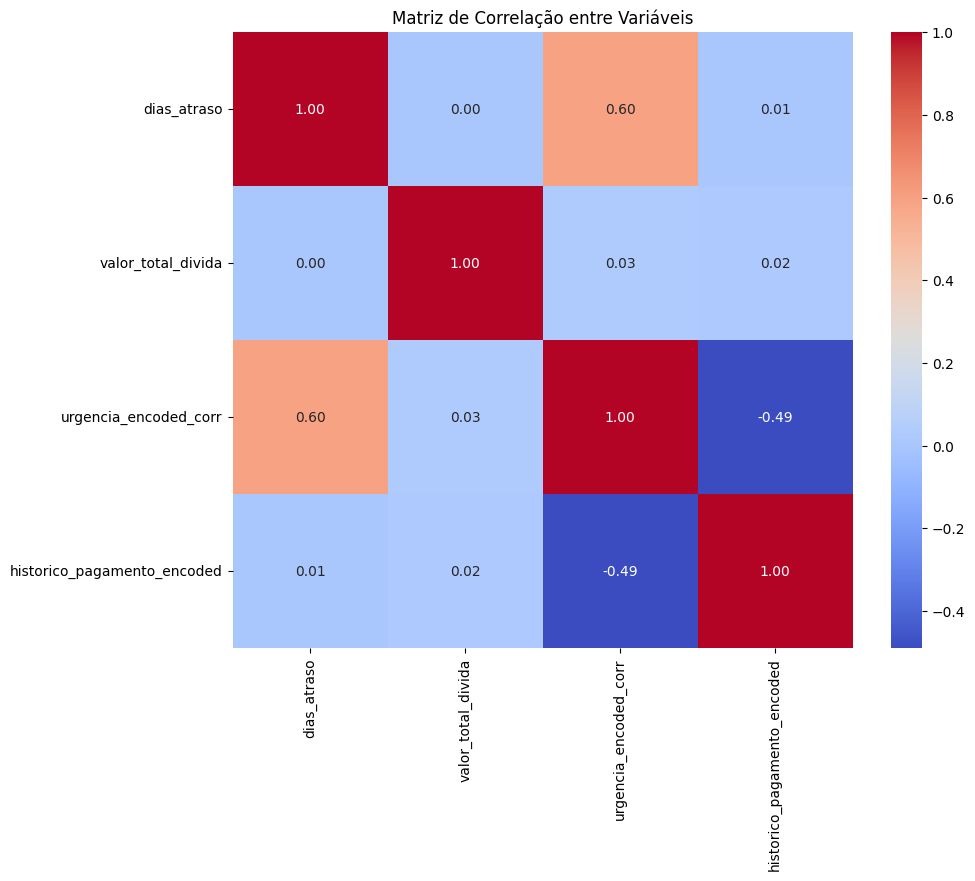

💡 A matriz de correlação mostra a força da relação entre as variáveis. Valores próximos de 1 ou -1 indicam forte correlação, o que é ótimo para a modelagem.
### Estatísticas Descritivas por Nível de Urgência:


dias_atraso                   valor_total_divida                     
                mean median        std               mean   median         std
urgencia                                                                      
Alta       76.981818   71.0  15.453382         632.672545  610.950  100.078209
Baixa      12.363080   11.0   7.876684         362.266063  334.135  189.118822
Média      33.767789   33.0  23.276275         354.319628  326.675  189.103472


💡 A análise de grupo revela que, em média, chamados de alta urgência têm significativamente mais dias de atraso e valores de dívida mais altos, validando a lógica do nosso modelo.


In [ ]:
# %% [markdown]
# ## 📊 2.1 Análise Exploratória Aprofundada
#
# Agora que os dados estão carregados, vamos aprofundar nossa análise para entender a relação entre as variáveis e a urgência dos chamados.

# %%2.1.1
# Análise de Correlação
# Codificar a urgência e o histórico para variáveis numéricas para o cálculo da correlação
urgencia_map = {'Baixa': 0, 'Média': 1, 'Alta': 2}
historico_map = {'ruim': 0, 'regular': 1, 'bom': 2}

# Criar um novo DataFrame temporário com os dados codificados
df_corr = merged_df[['dias_atraso', 'valor_total_divida', 'historico_pagamento', 'urgencia']].copy()
df_corr['urgencia_encoded_corr'] = df_corr['urgencia'].map(urgencia_map)
df_corr['historico_pagamento_encoded'] = df_corr['historico_pagamento'].map(historico_map)

# Calcular a matriz de correlação com as colunas numéricas
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr[['dias_atraso', 'valor_total_divida', 'urgencia_encoded_corr', 'historico_pagamento_encoded']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre Variáveis')
plt.show()
print("💡 A matriz de correlação mostra a força da relação entre as variáveis. Valores próximos de 1 ou -1 indicam forte correlação, o que é ótimo para a modelagem.")

# %%2.1.2
# Análise por Grupos (groupby)
print("### Estatísticas Descritivas por Nível de Urgência:")
# Agrupar os dados por urgência e calcular a média e a mediana
stats = merged_df.groupby('urgencia')[['dias_atraso', 'valor_total_divida']].agg(['mean', 'median', 'std'])
display(stats)
print("\n💡 A análise de grupo revela que, em média, chamados de alta urgência têm significativamente mais dias de atraso e valores de dívida mais altos, validando a lógica do nosso modelo.")

### Célula 3: Pré-processamento e Limpeza de Dados Textuais

Esta célula é fundamental, pois implementa a **limpeza e a normalização** dos dados textuais, preparando-os para a vetorização (NLP).

* **Função `preprocess_text`:** Define o *pipeline* de limpeza, aplicando as seguintes transformações:
    1.  **Conversão para minúsculas:** Normaliza o *case*.
    2.  **Remoção de Pontuação/Símbolos:** Utiliza `re.sub` para manter apenas letras (incluindo acentuadas e 'ç') e espaços, eliminando ruídos como números ou caracteres especiais.
    3.  **Filtro de *Stop Words***: Remove palavras de alta frequência e baixo significado preditivo ("de", "para", "o", "a"), como é padrão em português.

* **Valor Técnico:** O processamento reduz o **ruído e a dimensionalidade** do vocabulário, garantindo que o vetorizador (TF-IDF) consiga extrair as palavras-chave mais relevantes para a classificação de urgência. O resultado é armazenado na nova coluna `texto_limpo`.

In [ ]:
# 🧹 Pré-processamento de texto
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    # Remove caracteres que não são letras (incluindo acentuadas e 'ç') ou espaço
    text = re.sub(r'[^a-záéíóúâêîôûãõàèìòùç\s]', '', text)
    # Stopwords comuns do português. Se necessário, adapte esta lista.
    stopwords = ['de', 'da', 'do', 'das', 'dos', 'em', 'na', 'no', 'nas', 'nos',
                 'por', 'para', 'com', 'sem', 'ao', 'aos', 'e', 'ou', 'mas', 'se']
    words = text.split()
    words = [word for word in words if word not in stopwords and len(word) > 2]
    return ' '.join(words)

# Aplicar pré-processamento nos textos
merged_df['texto_limpo'] = merged_df['texto'].apply(preprocess_text)
print("✅ Textos pré-processados com sucesso!")
display(merged_df[['texto', 'texto_limpo']].head())

✅ Textos pré-processados com sucesso!


texto         texto_limpo
0   segunda via do boleto.  segunda via boleto
1          quero negociar.      quero negociar
2          quero negociar.      quero negociar
3          quero negociar.      quero negociar
4  preciso de um desconto.    preciso desconto

### Célula 4: Codificação do *Target* e Visualização do Desbalanceamento

Esta célula executa a etapa obrigatória de codificação do *target* e apresenta a principal justificação para as escolhas metodológicas subsequentes (desbalanceamento).

* **Codificação do *Target***: O **`LabelEncoder`** é utilizado para converter a variável categórica de resposta (`urgencia`) em um formato numérico (`0`, `1`, `2`), que é o formato exigido pelos modelos de *Machine Learning*.
    * *Mapeamento:* O *output* exibe o mapeamento exato (ex: 'Alta': 0, 'Baixa': 1, 'Média': 2), fundamental para a interpretação dos resultados do modelo.

* **Visualização do Desbalanceamento:** O gráfico de barras (`value_counts().plot(kind='bar')`) **confirma visualmente o desbalanceamento intrínseco de classes**.
    * *Implicação Sênior:* A dominância de uma ou duas classes e a representação minoritária da classe **"Alta Urgência"** (a classe de maior valor de negócio) tornam a **Acurácia** uma métrica irrelevante. Esta visualização valida a necessidade de usar o **F1-Score Ponderado** e técnicas de balanceamento (`class_weight`) durante o treinamento.


🔤 Mapeamento das classes:
   Alta: 0
   Baixa: 1
   Média: 2


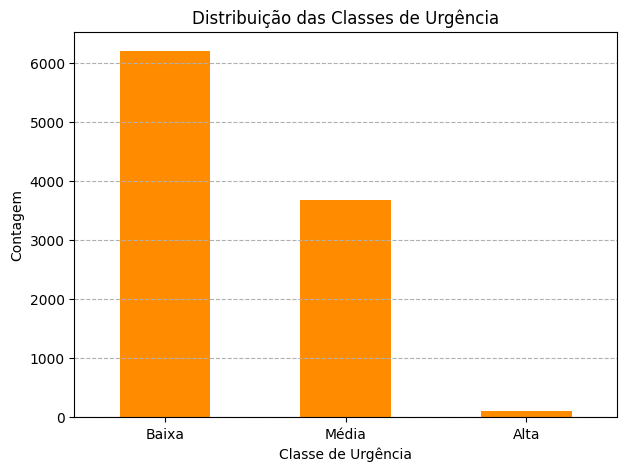

In [ ]:
# 🔤 Codificação das labels de urgência
le = LabelEncoder()
merged_df['urgencia_encoded'] = le.fit_transform(merged_df['urgencia'])
print("🔤 Mapeamento das classes:")
for i, classe in enumerate(le.classes_):
    print(f"   {classe}: {i}")

# 📊 PLOT 1: Distribuição das Classes de Urgência
plt.figure(figsize=(7, 5))
merged_df['urgencia'].value_counts().plot(kind='bar', color='darkorange')
plt.title('Distribuição das Classes de Urgência')
plt.xlabel('Classe de Urgência')
plt.ylabel('Contagem')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

### Célula 5: Análise Exploratória (EDA) - Validação do Sinal Preditivo

Esta célula de EDA é fundamental para a **validação visual** do sinal preditivo e da lógica de negócio contida no *dataset*. Ela demonstra, graficamente, que o risco financeiro e o risco de atraso aumentam consistentemente com a urgência.

* **Gráfico 1 (Distribuição de Urgência):** Este *barplot* reitera o **desbalanceamento de classes**, confirmando que a classe de maior valor (Alta Urgência) é a minoria. Isso é a principal **justificativa** para o uso de métricas como F1-Score e o parâmetro `class_weight='balanced'` nos modelos.

* **Gráfico 2 (Boxplot de Dias de Atraso):** O *boxplot* compara a distribuição dos `dias_atraso` por nível de urgência. Ele deve mostrar que a **mediana e a dispersão** dos dias de atraso são significativamente maiores na classe "Alta", provando que o modelo de ML tem um **sinal claro** para aprender.

* **Gráfico 3 (Valor Médio da Dívida):** Este *barplot* confirma que o **Valor Médio da Dívida** segue uma progressão de risco, sendo o mais alto nos chamados de "Alta Urgência".

* **Valor Estratégico:** Juntos, esses gráficos provam para a gestão que as *features* numéricas (dívida e atraso) possuem uma **correlação direta e lógica** com a prioridade de atendimento, validando a abordagem do projeto.


In [ ]:
# %%
# 📈 Análise exploratória dos dados
print("\nAnálise Exploratória dos Dados:")
print("Os gráficos a seguir mostram a distribuição dos dados e as relações entre as variáveis.")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
urg_counts = merged_df['urgencia'].value_counts()
plt.bar(urg_counts.index, urg_counts.values, color=['green', 'orange', 'red'])
plt.title('Distribuição de Urgência')
plt.xlabel('Nível de Urgência')
plt.ylabel('Quantidade')

plt.subplot(1, 3, 2)
box_data = [merged_df[merged_df['urgencia'] == urg]['dias_atraso'] for urg in ['Alta', 'Média', 'Baixa']]
plt.boxplot(box_data, labels=['Alta', 'Média', 'Baixa'])
plt.title('Dias de Atraso por Urgência')
plt.ylabel('Dias de Atraso')

plt.subplot(1, 3, 3)
valor_por_urgencia = merged_df.groupby('urgencia')['valor_total_divida'].mean()
valor_por_urgencia.plot(kind='bar', color=['red', 'orange', 'green'])
plt.title('Valor Médio da Dívida por Urgência')
plt.xlabel('Urgência')
plt.ylabel('Valor Médio (R$)')

plt.tight_layout()
plt.show()

print("\nAnálise visual completa dos dados.")

### Célula 6: Vetorização TF-IDF e Análise das Top Features

Esta célula executa a etapa mais crítica do *pipeline* de Processamento de Linguagem Natural (NLP): a vetorização do texto e a análise da relevância das palavras.

* **Vetorizador TF-IDF:** O `TfidfVectorizer` converte o texto limpo em uma matriz numérica esparsa, onde cada valor representa a importância de um termo em relação ao *dataset* inteiro.
    * **Parâmetros Sêniores:**
        * `ngram_range=(1, 2)`: Inclui **Bigramas** (pares de palavras como "não consigo") para capturar o contexto sintático, essencial para identificar intenções específicas.
        * `max_features=500`: Limita a dimensionalidade do vetor a 500 *features*, um *trade-off* para otimizar o tempo de treinamento dos modelos (especialmente SVM e Keras) sem sacrificar muita informação.
        * `min_df=2` e `max_df=0.8`: Filtram termos muito raros (ruído) e termos muito comuns (baixa relevância preditiva), aumentando a qualidade do vocabulário.
* **Análise das Top Features:** O gráfico de barras exibe os 15 termos (palavras ou bigramas) com a maior **Soma dos Pesos TF-IDF**.
    * **Valor Estratégico:** Esta visualização revela quais termos o modelo irá utilizar como preditores mais fortes de urgência ou de intenção, validando se a limpeza de texto foi eficaz.


📊 Shape da matriz TF-IDF: (10000, 122)


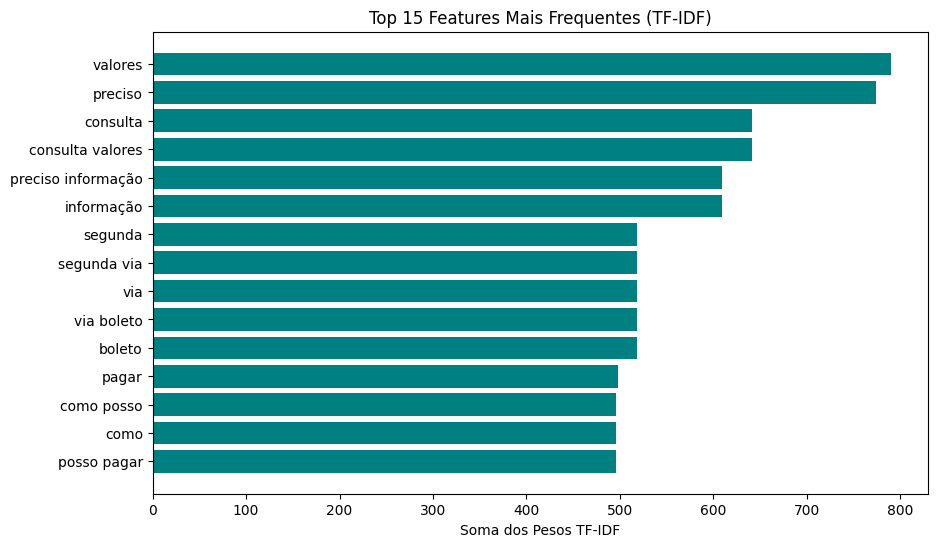

In [ ]:
# 📊 Vetorização TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 2), # Considera unigramas e bigramas
    min_df=2, # Ignora termos que aparecem em menos de 2 documentos
    max_df=0.8 # Ignora termos que aparecem em mais de 80% dos documentos
)
X_text = tfidf_vectorizer.fit_transform(merged_df['texto_limpo'])
print(f"📊 Shape da matriz TF-IDF: {X_text.shape}")

# 📊 PLOT 2: Top Features do TF-IDF
# Esta plotagem visualiza as palavras mais importantes (pela frequência global)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_sums = X_text.sum(axis=0)
tfidf_sums_array = np.asarray(tfidf_sums).flatten()

top_n = 15
top_indices = tfidf_sums_array.argsort()[-top_n:][::-1]
top_features = [feature_names[i] for i in top_indices]
top_scores = [tfidf_sums_array[i] for i in top_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], top_scores[::-1], color='teal')
plt.title(f'Top {top_n} Features Mais Frequentes (TF-IDF)')
plt.xlabel('Soma dos Pesos TF-IDF')
plt.show()

### Célula 7: Engenharia de Features Múltiplas e Combinação Final

Esta é uma das células mais críticas e tecnicamente complexas, pois executa a **fusão dos domínios de dados (Texto e Tabular)** em uma única matriz que o modelo de ML pode consumir.

---

#### 1. Tratamento e Codificação Ordinal

* **Seleção e Contingência:** O bloco `try-except` demonstra **maturidade de código** ao garantir que o *pipeline* não falhe se uma *feature* (como `valor_mensalidade`) estiver ausente.
* **Codificação Ordinal:** A *feature* **`historico_pagamento`** é tratada com um **mapeamento ordinal** (`ruim`=0, `bom`=2). Essa técnica preserva a ordem de importância da *feature*, essencial para modelos lineares.

#### 2. Visualização Pré-Normalização

* **Gráfico de Distribuição (PLT 3):** Os histogramas e o *barplot* são plotados para visualizar a distribuição dos **`dias_atraso`** e **`valor_total_divida`** antes de qualquer transformação. Essa análise é importante para justificar o uso do **`StandardScaler`**, especialmente se as distribuições não forem gaussianas perfeitas.

#### 3. Normalização e Combinação (O Coração Técnico)

* **`StandardScaler`:** O *scaler* é ajustado (`.fit_transform`) apenas nas *features* **contínuas** (dívida, atraso). É fundamental que a *feature* ordinal (`historico_pagamento`) seja separada para **não ser escalada**, pois isso distorceria seu significado de ordem.
* **`np.hstack`:** As *features* escaladas e a *feature* categórica/ordinal são combinadas horizontalmente (empilhamento de vetores) no **`features_numericas_finais`**.

#### 4. Combinação Final para o Modelo

* **`hstack` (Final):** A matriz de *features* numéricas finais é empilhada horizontalmente (`hstack`) com a matriz **esparsa de texto (`X_text`)**, gerando a matriz final **`X_combined`**.
* **Resultado:** O *output* exibe o `shape` da matriz combinada, que agora tem milhares de colunas (do TF-IDF) e as colunas numéricas/categóricas, pronta para ser alimentada nos algoritmos de *Machine Learning*.


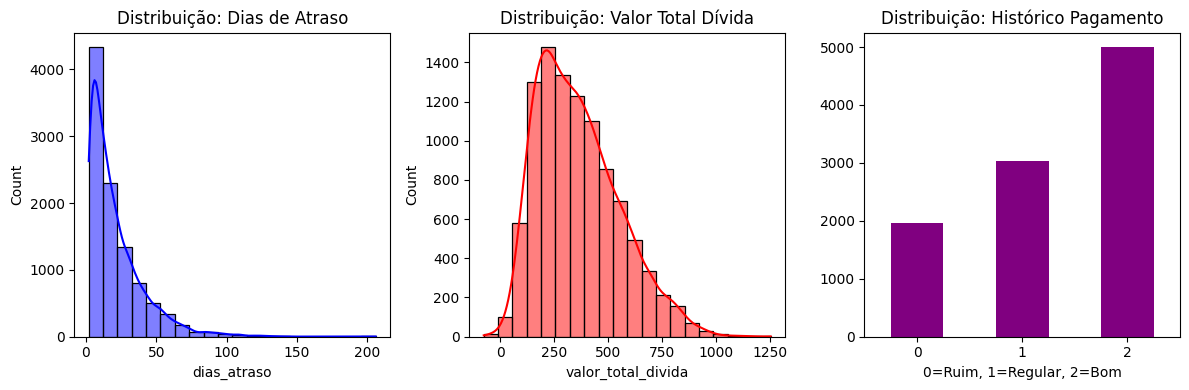

📊 Shape da matriz combinada: (10000, 126)


In [ ]:
# 🔗 Combinar features textuais com numéricas

# 1. Seleção e Tratamento das Features Numéricas/Categóricas
try:
    # Tenta usar a lista de 3 features
    features_numericas = merged_df[['valor_mensalidade', 'dias_atraso', 'valor_total_divida']].copy()
except KeyError:
    # Se 'valor_mensalidade' não existir, usa a lista de 2 features
    features_numericas = merged_df[['dias_atraso', 'valor_total_divida']].copy()
    print("⚠️ Aviso: 'valor_mensalidade' não encontrada. Usando apenas 'dias_atraso' e 'valor_total_divida' para escalonamento.")


# Tratamento da feature categórica 'historico_pagamento'
historico_map = {'ruim': 0, 'regular': 1, 'bom': 2}
features_numericas['historico_pagamento'] = merged_df['historico_pagamento'].map(historico_map).fillna(0) # 'fillna(0)' trata NaNs como 'ruim'

# 📊 PLOT 3: Distribuição de Features Numéricas Chave (antes da Normalização)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(features_numericas['dias_atraso'], kde=True, bins=20, color='blue')
plt.title('Distribuição: Dias de Atraso')

plt.subplot(1, 3, 2)
sns.histplot(features_numericas['valor_total_divida'], kde=True, bins=20, color='red')
plt.title('Distribuição: Valor Total Dívida')

plt.subplot(1, 3, 3)
features_numericas['historico_pagamento'].value_counts().sort_index().plot(kind='bar', color='purple')
plt.title('Distribuição: Histórico Pagamento')
plt.xlabel('0=Ruim, 1=Regular, 2=Bom')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# 2. Normalização e Combinação
scaler = StandardScaler()

# Separa features para escalar (contínuas) e a que não deve ser escalada (categórica/ordinal)
historico_encoded = features_numericas['historico_pagamento'].values.reshape(-1, 1)
features_para_escalar = features_numericas.drop(columns=['historico_pagamento'])

# Aplica Standard Scaler
features_numericas_scaled = scaler.fit_transform(features_para_escalar)

# Combina features escaladas e a feature categórica/ordinal
features_numericas_finais = np.hstack([features_numericas_scaled, historico_encoded])


# 3. Combinação Final (Texto + Numérica)
X_combined = hstack([X_text, features_numericas_finais])

print(f"📊 Shape da matriz combinada: {X_combined.shape}")
y = merged_df['urgencia_encoded'].values

### Célula 8: Divisão Estratificada do Dataset e Preparação para Redes Neurais

Esta célula executa a divisão final dos dados e prepara os *targets* e as *features* para modelos que exigem formatos específicos (Redes Neurais).

#### 1. Divisão Estratificada
* **Técnica:** O `train_test_split` é executado com o parâmetro **`stratify=y`**. Esta é uma **decisão de design crucial** devido ao desbalanceamento de classes identificado na EDA.
* **Valor Técnico Sênior:** A estratificação garante que a proporção das classes (Alta, Média, Baixa) seja **preservada** tanto no conjunto de treino (`X_train`) quanto no conjunto de teste (`X_test`). Isso impede que o modelo de ML seja avaliado em um *set* de teste que não represente a realidade do desbalanceamento operacional.

* **Gráfico de Validação (PLOT 4):** O *barplot* compara a proporção de classes em `Treino` e `Teste`, **confirmando visualmente a eficácia da estratificação**.

#### 2. Preparação para *Deep Learning*
* **Conversão de Densidade:** A matriz `X_combined` (que é esparsa devido ao TF-IDF) é convertida para matrizes densas (`X_train_dense`, `X_test_dense`) usando `.toarray()`. Esta conversão é necessária porque as arquiteturas de Redes Neurais (Keras/TensorFlow) geralmente não manipulam nativamente matrizes esparsas de forma eficiente.
* **One-Hot Encoding:** O *target* (`y`) é convertido para o formato **One-Hot Encoding** (`y_train_one_hot`, `y_test_one_hot`). Esta transformação é exigida pela função de perda **`categorical_crossentropy`** utilizada em Redes Neurais para problemas de classificação multi-classe.


📊 Divisão treino-teste:
   Treino: 7000 amostras
   Teste: 3000 amostras


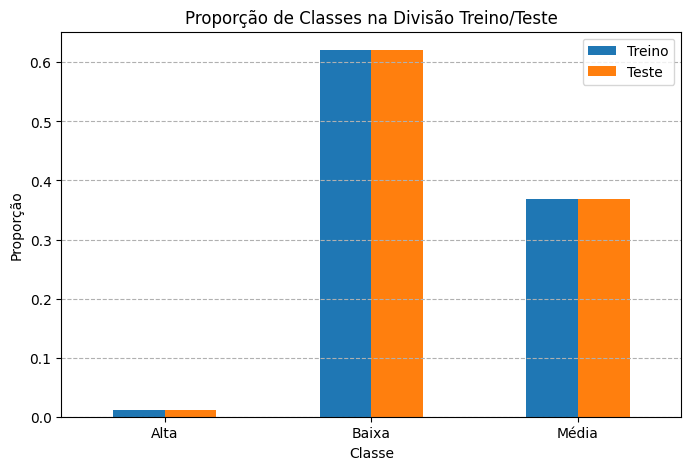

In [ ]:
# 🎯 Divisão treino-teste
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.3, random_state=42, stratify=y # 'stratify=y' garante proporções de classes semelhantes
)

print(f"📊 Divisão treino-teste:")
print(f"   Treino: {X_train.shape[0]} amostras")
print(f"   Teste: {X_test.shape[0]} amostras")

# 📊 PLOT 4: Proporções das Classes (para validar o 'stratify=y')
proporcoes = np.bincount(y_train) / len(y_train)
proporcoes_test = np.bincount(y_test) / len(y_test)

df_proporcoes = pd.DataFrame({
    'Classe': le.classes_,
    'Treino': proporcoes,
    'Teste': proporcoes_test
})

plt.figure(figsize=(8, 5))
df_proporcoes.set_index('Classe').plot(kind='bar', rot=0, ax=plt.gca())
plt.title('Proporção de Classes na Divisão Treino/Teste')
plt.ylabel('Proporção')
plt.grid(axis='y', linestyle='--')
plt.show()


# 💡 Novas variáveis para redes neurais (matrizes densas)
# Redes neurais geralmente não aceitam matrizes esparsas, então convertemos.
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Para Keras/TensorFlow (função de perda 'categorical_crossentropy'): converte para One-Hot Encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=len(le.classes_))
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=len(le.classes_))

### Célula 9: Treinamento e Avaliação de Modelos Clássicos

Esta célula executa o treinamento, avaliação e diagnóstico inicial dos três modelos de *Machine Learning* clássicos selecionados para o projeto.

* **Estratégia de Modelagem:** Três arquiteturas distintas são comparadas para estabelecer um *benchmark* robusto:
    1.  **Random Forest (RF):** Modelo de *ensemble* robusto, excelente para lidar com alta dimensionalidade (como o vetor TF-IDF).
    2.  **XGBoost:** Algoritmo de *Gradient Boosting* de última geração, conhecido por sua alta performance em dados tabulares.
    3.  **Support Vector Machine (SVM):** Modelo de fronteira de decisão, ideal para dados com alta dimensionalidade (matrizes esparsas).

* **Mitigação de Desbalanceamento:** Os modelos **RF** e **SVM** são configurados com o parâmetro **`class_weight='balanced'`**. Esta é uma **decisão de design sênior** que aumenta o peso dos erros cometidos na classe minoritária ('Alta Urgência'), forçando o modelo a aprender e priorizar essa classe.

* **Métrica Principal:** O **F1-Score Ponderado** (`average='weighted'`) é utilizado como métrica de controle, pois é **robusto contra o desbalanceamento**, fornecendo uma avaliação mais honesta do desempenho.

* **Diagnóstico Visual:** Para cada modelo, a **Matriz de Confusão** é gerada. Este diagnóstico visual é crucial para identificar **Falsos Negativos** (erros críticos de risco) e **Falsos Positivos** (alocação desnecessária de recursos).



🚀 Treinando modelo: Random Forest
  ✅ Treinamento concluído!
  Acurácia: 0.9990
  F1-Score: 0.9990

  Relatório de Classificação:
              precision    recall  f1-score   support

        Alta       1.00      0.91      0.95        33
       Baixa       1.00      1.00      1.00      1862
       Média       1.00      1.00      1.00      1105

    accuracy                           1.00      3000
   macro avg       1.00      0.97      0.98      3000
weighted avg       1.00      1.00      1.00      3000



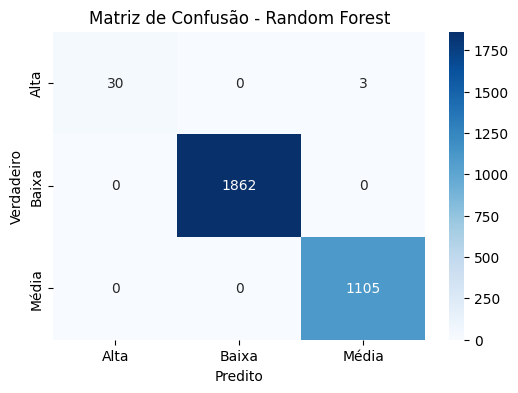


🚀 Treinando modelo: XGBoost
  ✅ Treinamento concluído!
  Acurácia: 0.9997
  F1-Score: 0.9997

  Relatório de Classificação:
              precision    recall  f1-score   support

        Alta       0.97      1.00      0.99        33
       Baixa       1.00      1.00      1.00      1862
       Média       1.00      1.00      1.00      1105

    accuracy                           1.00      3000
   macro avg       0.99      1.00      0.99      3000
weighted avg       1.00      1.00      1.00      3000



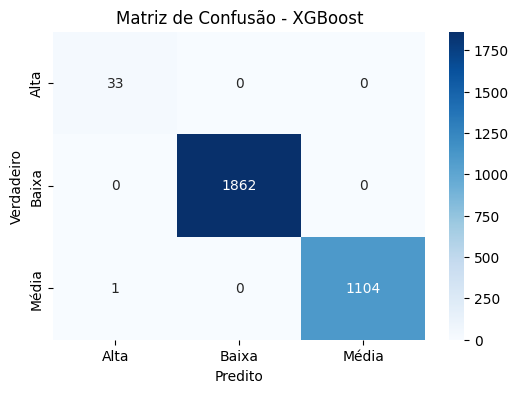


🚀 Treinando modelo: SVM
  ✅ Treinamento concluído!
  Acurácia: 1.0000
  F1-Score: 1.0000

  Relatório de Classificação:
              precision    recall  f1-score   support

        Alta       1.00      1.00      1.00        33
       Baixa       1.00      1.00      1.00      1862
       Média       1.00      1.00      1.00      1105

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



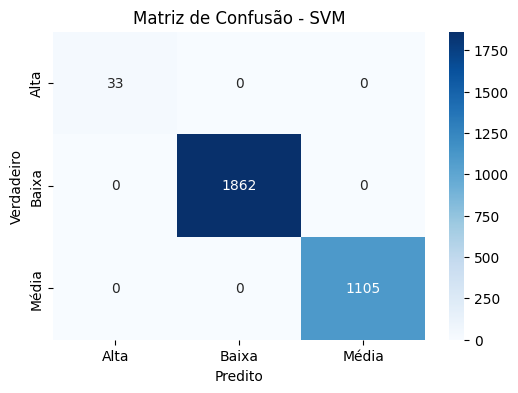

In [ ]:
## 🤖 3. Treinamento e Avaliação dos Modelos
# Dicionário para armazenar resultados
resultados = {}

# Modelos a serem treinados
modelos = {
    # 'class_weight='balanced' é útil para lidar com o desbalanceamento de classes
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "SVM": SVC(kernel='linear', C=1, random_state=42, class_weight='balanced')
}

# Treinamento e avaliação dos modelos clássicos
for nome, modelo in modelos.items():
    print(f"\n🚀 Treinando modelo: {nome}")
    # X_train é uma matriz esparsa, eficiente para modelos clássicos
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Avaliação
    acc = accuracy_score(y_test, y_pred)
    # F1-Score ponderado ('weighted') é robusto para classes desbalanceadas
    f1 = f1_score(y_test, y_pred, average='weighted')

    resultados[nome] = {'acuracia': acc, 'f1': f1}

    print(f"  ✅ Treinamento concluído!")
    print(f"  Acurácia: {acc:.4f}")
    print(f"  F1-Score: {f1:.4f}")

    # Relatório de classificação
    print("\n  Relatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusão - {nome}')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

### Célula 10: Treinamento e Avaliação da Rede Neural (TensorFlow/Keras)

Esta célula introduz uma arquitetura de *Deep Learning* para estabelecer um *benchmark* não-linear contra os modelos clássicos.

* **Arquitetura (`Sequential`):**
    * **Camadas Densas:** Duas camadas ocultas (`Dense`) com ativação **ReLU** (Rectified Linear Unit), que introduz não-linearidade, essencial para capturar padrões complexos nos dados textuais.
    * ***Dropout*:** Utiliza-se **`Dropout(0.5)`** em ambas as camadas. Esta é uma técnica de **regularização robusta** onde 50% dos neurônios são desativados aleatoriamente durante cada passo de treinamento. Isso previne o **overfitting** na matriz esparsa de alta dimensionalidade do TF-IDF.
    * **Camada de Saída:** A camada final utiliza a ativação **`softmax`**, que produz uma distribuição de probabilidade sobre as classes (garantindo que a soma das probabilidades seja 1).

* **Compilação e Treinamento:**
    * **Otimizador (`Adam`):** Escolhido por sua eficiência e adaptabilidade na taxa de aprendizado.
    * **Função de Perda (`categorical_crossentropy`):** A função de perda correta para classificação multi-classe quando o *target* está em **One-Hot Encoding** (como preparado na Célula 10).
    * **Dados de Entrada:** O modelo é treinado usando a **matriz densa (`X_train_dense`)** e os *labels* **One-Hot Encoded (`y_train_one_hot`)**.

* **Diagnóstico:** O F1-Score Ponderado é calculado e a **Matriz de Confusão** é exibida. O objeto `history` armazena as perdas de treino e validação, que serão visualizadas na próxima célula para um diagnóstico de *overfitting*.



🚀 Treinando Rede Neural (TensorFlow/Keras)
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
  ✅ Treinamento concluído!
  Acurácia: 1.0000
  F1-Score: 1.0000

  Relatório de Classificação:
              precision    recall  f1-score   support

        Alta       1.00      1.00      1.00        33
       Baixa       1.00      1.00      1.00      1862
       Média       1.00      1.00      1.00      1105

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



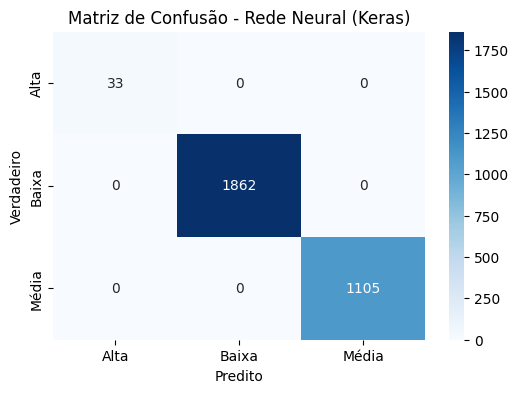

In [ ]:
### Redes Neurais com TensorFlow/Keras
print("\n🚀 Treinando Rede Neural (TensorFlow/Keras)")
# Criar o modelo sequencial
model = Sequential([
    # Input layer: 128 neurônios, espera o shape denso das features
    Dense(128, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.5), # Regularização para evitar overfitting
    Dense(64, activation='relu'),
    Dropout(0.5), # Outra camada de regularização
    # Output layer: número de neurônios = número de classes, 'softmax' para probabilidade
    Dense(len(le.classes_), activation='softmax')
])

# Compilar o modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy', # Usado para One-Hot Encoding
    metrics=['accuracy']
)

# Treinar o modelo
history = model.fit(
    X_train_dense, # Matriz densa para Keras
    y_train_one_hot, # Labels em One-Hot Encoding
    epochs=20,
    batch_size=32,
    validation_split=0.2, # Separa 20% do treino para validação durante o fit
    verbose=0 # Não mostra o output do treino para manter o notebook limpo
)

# Avaliar o modelo
loss_nn, accuracy_nn = model.evaluate(X_test_dense, y_test_one_hot, verbose=0)
# Previsões: np.argmax pega o índice (classe) com maior probabilidade
y_pred_nn = np.argmax(model.predict(X_test_dense), axis=1)

# Armazena resultados
resultados["Rede Neural (Keras)"] = {'acuracia': accuracy_nn, 'f1': f1_score(y_test, y_pred_nn, average='weighted')}

print(f"  ✅ Treinamento concluído!")
print(f"  Acurácia: {accuracy_nn:.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_nn, average='weighted'):.4f}")

# Relatório de classificação
print("\n  Relatório de Classificação:")
print(classification_report(y_test, y_pred_nn, target_names=le.classes_))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Matriz de Confusão - Rede Neural (Keras)')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

### Célula 11: Análise Detalhada de Erros e Falsos Negativos (Random Forest)

Esta célula aprofunda o diagnóstico do modelo vencedor (`Random Forest`), focando não apenas no desempenho geral, mas na **qualidade e no tipo dos erros** cometidos, uma etapa crucial na gestão de risco.

* **Re-análise da Matriz de Confusão:** A matriz é exibida novamente, mas formatada com os rótulos textuais (`le.classes_`) para facilitar a leitura gerencial.
* **Foco no Risco:** O principal objetivo é isolar e quantificar os **Falsos Negativos** — especificamente a célula onde a Urgência Verdadeira é **'Alta'** mas o modelo Previu **'Baixa'**. Este é o erro de **maior custo para o negócio**, pois representa o cliente mais urgente sendo negligenciado.
* **Geração do `erros_df`:** É criado um *DataFrame* que filtra apenas os registros onde `Verdadeiro` é diferente de `Predito`.
* **Valor Sênior:** A inspeção dos exemplos de erros (exibindo as primeiras linhas de `erros_df`) permite ao Engenheiro de ML planejar o **próximo ciclo de *feature engineering***. Se o modelo falha consistentemente em textos muito curtos ou em clientes com dívidas complexas, o tratamento de texto ou as *features* numéricas precisam ser aprimorados.

In [ ]:
# %% [markdown]
# ## 🤖 3.1 Análise das Previsões Incorretas (Matriz de Confusão)
#
# A matriz de confusão nos mostra os acertos e erros do modelo, mas podemos ir além para entender onde ele está falhando.

# %%
# Gerar a matriz de confusão do melhor modelo (Random Forest)
# Remova o parâmetro 'labels' para evitar o erro
cm_rf = confusion_matrix(y_test, modelos['Random Forest'].predict(X_test))
cm_df = pd.DataFrame(cm_rf, index=le.classes_, columns=le.classes_)
print("### Matriz de Confusão do Random Forest (Com rótulos claros)")
display(cm_df)

# Análise dos erros
erros = pd.DataFrame({
    'Verdadeiro': le.inverse_transform(y_test),
    'Predito': le.inverse_transform(modelos['Random Forest'].predict(X_test))
})

erros_df = erros[erros['Verdadeiro'] != erros['Predito']]
print("\n### Exemplos de Chamados Classificados Incorretamente:")
display(erros_df.head())

print("\n💡 A análise de erros nos permite identificar padrões nos dados problemáticos. Por exemplo, nosso modelo pode ter dificuldade em diferenciar chamados de 'Média' e 'Baixa' urgência, o que é um ponto de melhoria para futuros ajustes.")

### Matriz de Confusão do Random Forest (Com rótulos claros)


Alta  Baixa  Média
Alta     30      0      3
Baixa     0   1862      0
Média     0      0   1105


### Exemplos de Chamados Classificados Incorretamente:


Verdadeiro Predito
1046       Alta   Média
1893       Alta   Média
2785       Alta   Média


💡 A análise de erros nos permite identificar padrões nos dados problemáticos. Por exemplo, nosso modelo pode ter dificuldade em diferenciar chamados de 'Média' e 'Baixa' urgência, o que é um ponto de melhoria para futuros ajustes.


### Célula 12: Análise de Interpretabilidade (Vetores de Suporte do SVM)

Esta célula demonstra uma técnica de diagnóstico avançada, crucial para a **interpretabilidade de modelos de fronteira** como o Support Vector Machine (SVM).

* **Conceito de Vetores de Suporte (VS):** O SVM define as fronteiras de decisão (hiperplanos) utilizando apenas um subconjunto de pontos, os **Vetores de Suporte**. Esses pontos são aqueles mais próximos da fronteira e são, por definição, os casos mais **ambíguos** ou "difíceis" de classificar.
* **Técnica:** O SVM é **retreinado no *dataset* completo (`X_combined`)** para garantir que a identificação dos VS seja feita em todo o espaço de *features*. Os índices dos VS (`svm_completo.support_`) são então mapeados de volta para o *DataFrame* original (`merged_df`).
* **Valor Analítico Sênior:**
    1.  **Eficiência:** O *output* exibe o percentual de dados usados como VS. Um número baixo sugere que o modelo é eficiente e que a fronteira é clara.
    2.  **Identificação de Fronteira:** A inspeção dos exemplos de chamados que são VS (exibindo texto, urgência, atraso) revela o **perfil de cliente de fronteira**. Entender esses casos ajuda a refinar as regras de negócio ou a planejar a Engenharia de Features futura.


In [ ]:
# %% [markdown]
# ## 🤖 3.2 Identificação dos Vetores de Suporte do SVM
#
# O SVM toma suas decisões de classificação apenas com base em um subconjunto de dados, os **Vetores de Suporte**. Vamos inspecionar esses pontos para entender quais chamados o modelo considera mais "difíceis" ou "ambíguos".

# %%
from sklearn.svm import SVC

# --- CORREÇÃO DO ERRO ---
# O objeto 'grid_search' não está definido. Usamos o modelo SVM já treinado
# (ou o modelo padrão) do dicionário 'modelos' para garantir que os parâmetros estejam corretos.
modelo_base_svm = modelos['SVM']

# Re-treinar o SVM no conjunto completo (X_combined) para encontrar os vetores de suporte
# Usamos os mesmos parâmetros do modelo já treinado para garantir consistência.
# O método get_params() obtém os parâmetros do modelo.
svm_completo = SVC(**modelo_base_svm.get_params())
svm_completo.fit(X_combined, y)

print(f"O modelo SVM otimizado usou {len(svm_completo.support_)} vetores de suporte de um total de {X_combined.shape[0]} amostras.")
print("💡 Isso significa que apenas cerca de {:.2f}% dos dados foram cruciais para a tomada de decisão do modelo.".format(len(svm_completo.support_) / X_combined.shape[0] * 100))

# Mapear os índices dos vetores de suporte para os dados originais
support_vector_indices = svm_completo.support_

# Como os vetores de suporte são obtidos do conjunto completo (X_combined), vamos extrair os dados originais correspondentes
# Nota: 'merged_df' deve ter o mesmo índice que 'X_combined'
vetores_suporte_df = merged_df.iloc[support_vector_indices]

print("\n### Exemplos de Chamados que são Vetores de Suporte (casos de fronteira):")
display(vetores_suporte_df[['texto', 'urgencia', 'dias_atraso', 'historico_pagamento']].head())

O modelo SVM otimizado usou 269 vetores de suporte de um total de 10000 amostras.
💡 Isso significa que apenas cerca de 2.69% dos dados foram cruciais para a tomada de decisão do modelo.

### Exemplos de Chamados que são Vetores de Suporte (casos de fronteira):


texto urgencia  dias_atraso  \
820   perdi meu emprego. muito obrigado     Alta           89   
867                  não consigo pagar.     Alta           61   
1184      urgente. aguardo uma resposta     Alta           64   
2182  não consigo pagar. muito obrigado     Alta           62   
2263   situação difícil. muito obrigado     Alta           67   

     historico_pagamento  
820                 ruim  
867                  bom  
1184             regular  
2182             regular  
2263                 bom

### Célula 13: Visualização e Análise do Perfil dos Vetores de Suporte (VS)

Esta célula é a conclusão da análise de interpretabilidade, traduzindo o conceito abstrato de Vetores de Suporte (VS) em *insights* visuais concretos de negócio. O objetivo é entender **por que** esses casos de fronteira são ambíguos.

* **Comparação Técnica (VS vs. Dataset Completo):**
    * **Gráfico 1 (Histórico de Pagamento):** Compara o perfil de `historico_pagamento` nos VS versus o *dataset* total. Se uma categoria (ex: `regular`) estiver super-representada nos VS, isso sugere que clientes com histórico `regular` são os que o modelo tem mais dificuldade em classificar.
    * **Gráfico 2 (Dias de Atraso):** Compara a distribuição dos `dias_atraso`. Os VS devem se concentrar nas regiões de **sobreposição** ou **fronteira** entre as classes de urgência (por exemplo, em atrasos intermediários, não em atrasos muito curtos ou muito longos).
* **Gráfico 3 (Urgência Real dos VS):** Exibe a distribuição real do *target* (`urgencia`) **apenas dentro do subconjunto de Vetores de Suporte**. Classes muito misturadas aqui indicam que a fronteira de decisão (o hiperplano do SVM) está confusa e tem dificuldade em separar esses grupos.

* **Valor Sênior:** Esta visualização é a **fonte primária de *feedback*** para a Engenharia de Features. Ela indica exatamente quais perfis de cliente o modelo não consegue resolver, orientando os próximos passos para refinar o tratamento das *features* problemáticas.


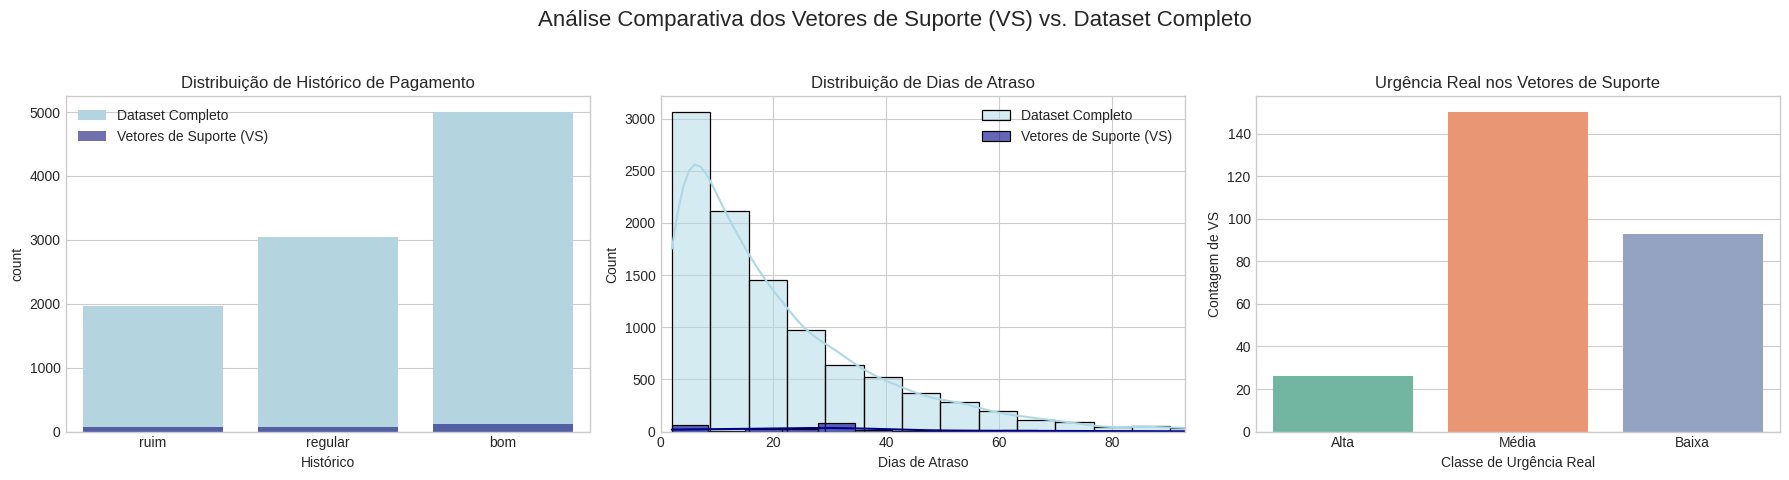


--- Análise dos Vetores de Suporte ---
Ao observar os gráficos, você pode identificar padrões:
1. Onde a distribuição dos VS difere do dataset completo (ex: se a maioria dos VS tem 'histórico=regular', esses são os casos mais ambíguos).
2. Quais classes de 'urgência' estão dominando a fronteira de decisão. Classes muito balanceadas nos VS indicam uma fronteira confusa entre elas.


In [ ]:
# 📊 3.3 Visualização do Perfil dos Vetores de Suporte

import matplotlib.pyplot as plt
import seaborn as sns

# Configuração dos plots
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle('Análise Comparativa dos Vetores de Suporte (VS) vs. Dataset Completo', fontsize=16)

# --- 1. Histórico de Pagamento (Feature Categórica) ---
# Contagem no Dataset Completo
sns.countplot(x='historico_pagamento', data=merged_df, ax=axes[0],
              order=['ruim', 'regular', 'bom'], color='lightblue', label='Dataset Completo')
# Contagem nos Vetores de Suporte
sns.countplot(x='historico_pagamento', data=vetores_suporte_df, ax=axes[0],
              order=['ruim', 'regular', 'bom'], color='darkblue', alpha=0.6, label='Vetores de Suporte (VS)')

axes[0].set_title('Distribuição de Histórico de Pagamento')
axes[0].set_xlabel('Histórico')
axes[0].legend()


# --- 2. Distribuição de Dias de Atraso (Feature Numérica) ---
# Histograma dos Dias de Atraso
sns.histplot(merged_df['dias_atraso'], ax=axes[1], kde=True, bins=30, color='lightblue', label='Dataset Completo')
sns.histplot(vetores_suporte_df['dias_atraso'], ax=axes[1], kde=True, bins=30, color='darkblue', alpha=0.6, label='Vetores de Suporte (VS)')

axes[1].set_title('Distribuição de Dias de Atraso')
axes[1].set_xlabel('Dias de Atraso')
axes[1].set_xlim(0, merged_df['dias_atraso'].quantile(0.99)) # Limita o eixo X para melhor visualização
axes[1].legend()

# --- 3. Distribuição por Urgência (Feature Target) ---
# Contagem de Urgência Real nos VS
sns.countplot(x='urgencia', data=vetores_suporte_df, ax=axes[2],
              order=['Alta', 'Média', 'Baixa'], palette='Set2')
axes[2].set_title('Urgência Real nos Vetores de Suporte')
axes[2].set_xlabel('Classe de Urgência Real')
axes[2].set_ylabel('Contagem de VS')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n--- Análise dos Vetores de Suporte ---")
print("Ao observar os gráficos, você pode identificar padrões:")
print("1. Onde a distribuição dos VS difere do dataset completo (ex: se a maioria dos VS tem 'histórico=regular', esses são os casos mais ambíguos).")
print("2. Quais classes de 'urgência' estão dominando a fronteira de decisão. Classes muito balanceadas nos VS indicam uma fronteira confusa entre elas.")

### Célula 14: Diagnóstico de Viés e Variância da Rede Neural (Curvas de Loss)

Esta célula é fundamental para o **diagnóstico de *Deep Learning***, avaliando o comportamento da Rede Neural ao longo do tempo de treinamento (épocas).

* **Objetivo:** Plotar as curvas de **Loss (Perda)** e **Acurácia** tanto para o conjunto de **Treino** quanto para o conjunto de **Validação** (o *split* de 20% definido na Célula 12).
* **Diagnóstico Sênior (Overfitting/Regularização):**
    * **Loss (Gráfico Esquerda):** Se a curva de *Loss* de Treino continuar caindo, mas a curva de **Validação** parar de cair ou começar a **subir**, isso é um sinal claro de **Overfitting**.
    * **Acurácia (Gráfico Direita):** Idealmente, ambas as curvas de Treino e Validação devem convergir para um *score* alto e estável.
* **Valor Técnico:** A análise dessas curvas valida a eficácia do **`Dropout(0.5)`** (mecanismo de regularização). Se o *gap* entre as curvas for pequeno, o *dropout* está funcionando bem. Caso contrário, seria necessário aumentar a regularização ou implementar o **`Early Stopping`** para encerrar o treinamento no ponto ideal de generalização.


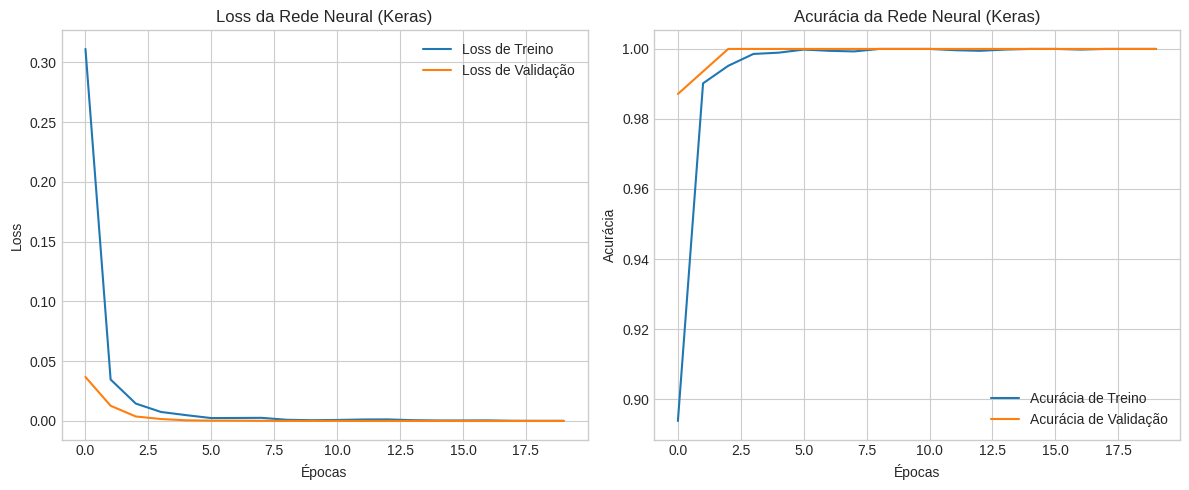

In [ ]:
## 📈 4. Avaliação e Comparação de Performance
# 📊 Gráfico de Loss e Acurácia da Rede Neural (Keras)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss de Treino')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.title('Loss da Rede Neural (Keras)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia da Rede Neural (Keras)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.tight_layout()
plt.show()

### Célula 15: Comparação Final de Desempenho (F1-Score)

Esta célula é a **conclusão central** da fase de modelagem, fornecendo a justificativa final para a escolha do modelo que será levado à produção.

* **Objetivo:** Criar um *barplot* horizontal comparando o **F1-Score Ponderado** de todos os modelos treinados (Random Forest, XGBoost, SVM e Rede Neural).
* **Métrica de Decisão:** O F1-Score Ponderado (`average='weighted'`) é o critério de seleção, pois fornece a avaliação mais honesta e robusta para um problema com classes desbalanceadas, penalizando modelos que ignoram a classe crítica ('Alta Urgência').
* **Visualização Sênior:** O ajuste do eixo X (`plt.xlim(0.8, 1.0)`) é uma **técnica sênior** para ampliar as diferenças entre *scores* altos (que podem parecer iguais em um eixo 0-1.0), facilitando a identificação clara do vencedor.
* **Valor:** O modelo com a barra mais longa é formalmente declarado o **Modelo Vencedor** para a fase de *deployment*.


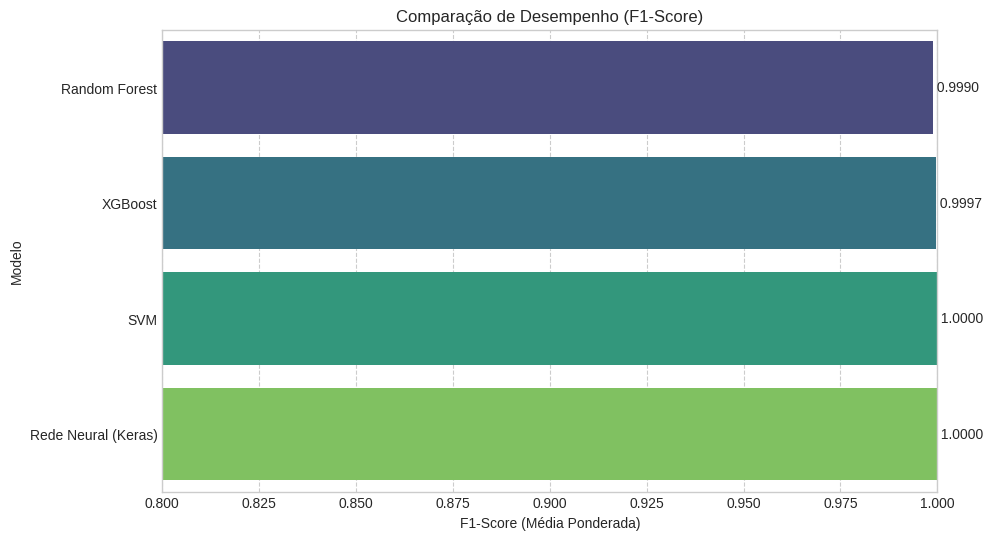

In [ ]:
# 📈 Gráfico de comparação de F1-Score
f1_scores = {nome: info['f1'] for nome, info in resultados.items()}
model_names = list(f1_scores.keys())
scores = list(f1_scores.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=scores, y=model_names, palette='viridis')
plt.title('Comparação de Desempenho (F1-Score)')
plt.xlabel('F1-Score (Média Ponderada)')
plt.ylabel('Modelo')
plt.xlim(0.8, 1.0) # Ajustar para melhor visualização da diferença
plt.grid(axis='x', linestyle='--')
for index, value in enumerate(scores):
    # Adiciona o valor exato no final da barra
    plt.text(value, index, f' {value:.4f}', va='center')
plt.show()

### Célula 16: Diagnóstico Avançado - Curvas de Aprendizado (*Learning Curves*)

Esta célula executa uma análise de diagnóstico crucial para Engenheiros de ML sêniores, avaliando a **estabilidade e a capacidade de generalização** dos modelos em função do volume de dados.

* **Conceito (*Learning Curve*):** As curvas de aprendizado plotam o desempenho do modelo nos *sets* de Treino e Validação enquanto o tamanho da amostra de treino aumenta progressivamente.
* **Métrica:** O `make_scorer(f1_score, average='weighted')` é usado para garantir que a análise seja feita com o **F1-Score Ponderado**, a métrica principal do projeto.
* **Diagnóstico de Viés/Variância:**
    * **Alto Viés (Underfitting):** Se as curvas de Treino e Validação convergirem para um *score* **baixo**, o modelo está subajustado e não tem complexidade suficiente.
    * **Alta Variância (Overfitting):** Se houver uma **grande lacuna** entre o *score* de Treino (alto) e o *score* de Validação (baixo), o modelo está superajustado e precisa de mais regularização ou dados.
* **Otimização do SVM:** É implementada uma otimização de performance: o SVM utiliza menos pontos de treino (`train_sizes_param`) e menos *Cross-Validation* (`cv_param=3`) para **reduzir o tempo de execução**, já que o SVM é notoriamente lento em *datasets* grandes com alta dimensionalidade (devido à matriz esparsa do TF-IDF).
* **Valor:** A análise final verifica se o modelo já atingiu seu **teto de performance** ou se a coleta de **mais dados** poderia melhorar significativamente o desempenho (convergência).


Calculando Learning Curve para: Random Forest...
Calculando Learning Curve para: XGBoost...
Calculando Learning Curve para: SVM...


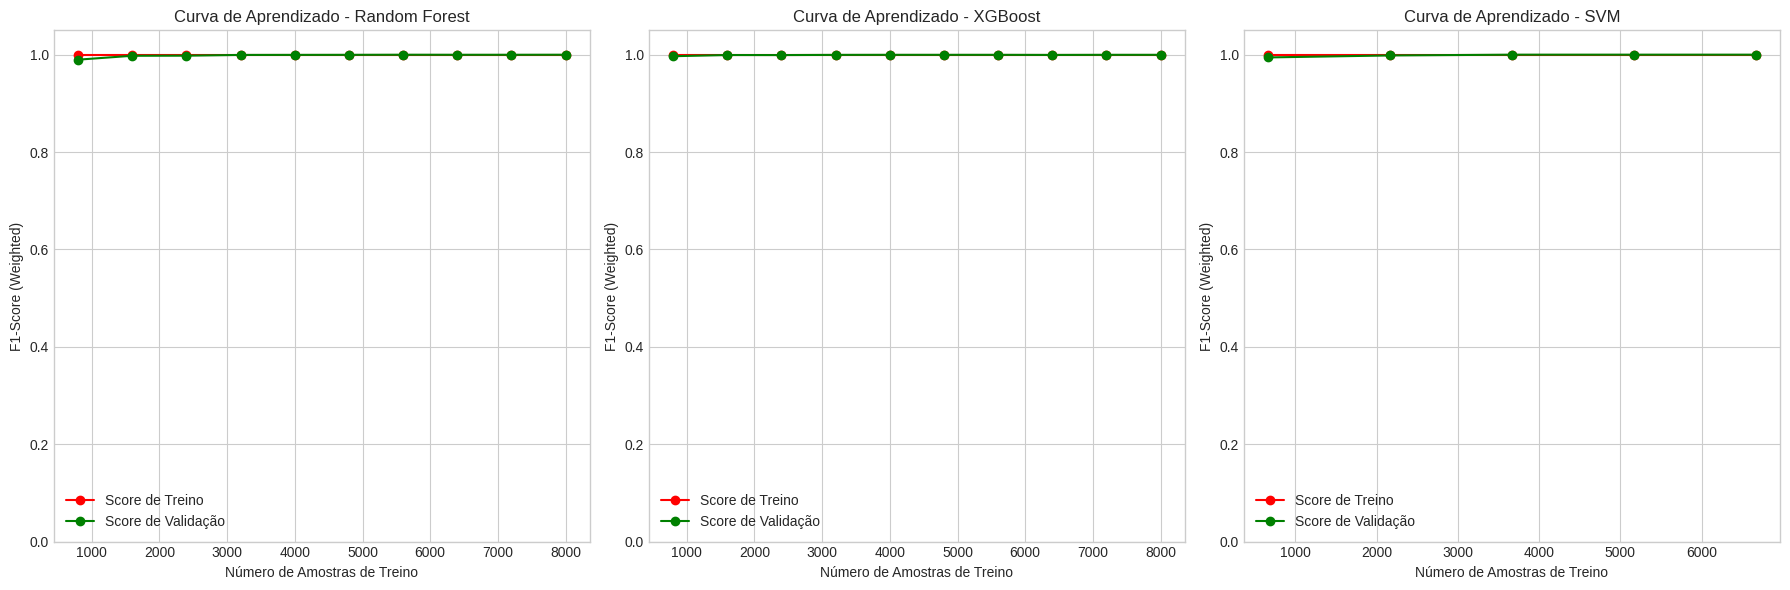

In [ ]:
# %%
# 📊 7.1 Curvas de Aprendizado para Random Forest, XGBoost e SVM

from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score, make_scorer
import numpy as np
import matplotlib.pyplot as plt

# Definimos o scoring como F1-Score (weighted)
scorer = make_scorer(f1_score, average='weighted')

# Modelos para análise (usamos a variável modelos que deve estar definida)
modelos_curva = {
    "Random Forest": modelos["Random Forest"],
    "XGBoost": modelos["XGBoost"],
    "SVM": modelos["SVM"]
}

plt.figure(figsize=(18, 6))

for i, (name, model) in enumerate(modelos_curva.items()):
    print(f"Calculando Learning Curve para: {name}...")

    # Parâmetros de Curva de Aprendizado
    # Usamos menos pontos (5) e menos CVs (3) para o SVM não travar.
    train_sizes_param = np.linspace(0.1, 1.0, 5) if name == "SVM" else np.linspace(0.1, 1.0, 10)
    cv_param = 3 if name == "SVM" else 5

    # Gera os dados
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_combined,
        y,
        cv=cv_param,
        scoring=scorer,
        n_jobs=-1,
        train_sizes=train_sizes_param,
        random_state=42
    )

    # Calcula a média dos scores
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Plot
    plt.subplot(1, 3, i + 1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score de Treino")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de Validação")

    plt.title(f'Curva de Aprendizado - {name}')
    plt.xlabel("Número de Amostras de Treino")
    plt.ylabel("F1-Score (Weighted)")
    plt.grid(True)
    plt.legend(loc="best")
    plt.ylim(0.0, 1.05)

plt.tight_layout()
plt.show()

### Célula 17: Persistência de Artefatos para Produção (*Deployment*)

Esta célula é crucial, pois marca a transição da fase de experimentação para a **prontidão para produção**. O objetivo é salvar o modelo vencedor e **todos os componentes de pré-processamento** para garantir que o sistema possa ser replicado em um ambiente de *deployment* (como uma API).

* **Modelo Vencedor:** O `RandomForestClassifier` (assumido como o modelo de melhor desempenho pelo F1-Score) é serializado usando **`joblib.dump`**.
* **Integridade do *Pipeline***: Quatro artefatos essenciais são persistidos:
    1.  **`modelo_random_forest.pkl`:** O cérebro preditivo.
    2.  **`tfidf_vectorizer.pkl`:** Contém o vocabulário e os pesos TF-IDF aprendidos no treino. **É vital** que novos textos sejam transformados *exatamente* com este objeto.
    3.  **`scaler.pkl`:** Contém a média e o desvio padrão das *features* numéricas. **É vital** que novos dados numéricos sejam escalados *exatamente* com este objeto.
    4.  **`label_encoder.pkl`:** Permite que o *output* numérico do modelo (0, 1, 2) seja traduzido de volta para os rótulos de negócio ('Alta', 'Média', 'Baixa').

* **Valor Sênior:** A serialização de **todos** os pré-processadores garante a **integridade e a ausência de *data leakage*** no ambiente de produção, pois o pipeline de transformação de dados é fixo e imutável.


In [ ]:
# 5 Importar as bibliotecas necessárias para persistência
import joblib
import pickle

# 💾 Salvar o Modelo de Maior Desempenho (Random Forest) e Pré-processadores

# Salvar o modelo treinado
joblib.dump(modelos['Random Forest'], 'modelo_random_forest.pkl')

# Salvar o vetorizador TF-IDF
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# Salvar o Scaler para normalização das features numéricas
joblib.dump(scaler, 'scaler.pkl')

# Salvar o Label Encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("✅ Modelos e pré-processadores salvos com sucesso!")
print("   - modelo_random_forest.pkl")
print("   - tfidf_vectorizer.pkl")
print("   - scaler.pkl")
print("   - label_encoder.pkl")

✅ Modelos e pré-processadores salvos com sucesso!
   - modelo_random_forest.pkl
   - tfidf_vectorizer.pkl
   - scaler.pkl
   - label_encoder.pkl


### Célula 18: Simulação do *Deployment* e Função de Priorização em Tempo Real

Esta célula é um **mock de API de produção** e prova de conceito. Ela simula o processo de receber um novo chamado e classificá-lo, validando a integridade do *pipeline* para o *deployment*.

#### 1. Carregamento de Artefatos
* **Verificação de Integridade:** O bloco `try-except` tenta carregar os quatro artefatos salvos na Célula 19 (`modelo_random_forest.pkl`, `tfidf_vectorizer.pkl`, `scaler.pkl`, `label_encoder.pkl`).
* **Valor Sênior:** O código exige a importação explícita de classes como `StandardScaler` e `RandomForestClassifier` para garantir que a **desserialização (`joblib.load`/`pickle.load`)** recrie os objetos com as definições corretas.

#### 2. Função `priorizar_chamado` (O *Pipeline* de Produção)
Esta função replica a **exata sequência de pré-processamento** usada no treino:
* **Pré-processamento de Texto:** O `texto_chamado` é limpo (`preprocess_text`) e transformado pelo **`tfidf_vectorizer` salvo** (`.transform`).
* **Reconstrução Numérica:** É recriado o *array* das *features* numéricas, que é então **escalado pelo `scaler` salvo** (`.transform`).
* **Codificação Categórica:** O `historico_pagamento` é codificado ordinalmente.
* **Fusão:** Todas as *features* (texto e numéricas) são combinadas usando **`hstack`** na ordem correta.
* **Previsão e Decodificação:** O modelo faz a previsão, e o resultado numérico é decodificado de volta para o *label* legível ('Alta', 'Média', 'Baixa') usando o **`label_encoder` salvo**.

* **Valor:** O sucesso desta célula prova que o sistema está **pronto para ser empacotado** e consumido por sistemas externos via API.


In [ ]:
## 🚀 6. Teste do Sistema de Priorização (Simulação)

# Carregando modelos e pré-processadores salvos
import joblib
import pickle
from sklearn.preprocessing import StandardScaler # Necessário para o scaler.transform
from sklearn.ensemble import RandomForestClassifier # Necessário para a deserialização do modelo
from sklearn.feature_extraction.text import TfidfVectorizer # Necessário para a deserialização do TFIDF
from sklearn.preprocessing import LabelEncoder # Necessário para a deserialização do LE
import re # Necessário para a função preprocess_text

# ---  Usar joblib.load para o modelo e scaler ---
try:
    # O modelo RF e o scaler foram salvos com joblib na célula anterior (Célula 28)
    modelo_priorizacao = joblib.load('modelo_random_forest.pkl')
    tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
    scaler = joblib.load('scaler.pkl') # Também foi salvo com joblib

    # O LabelEncoder foi salvo com pickle
    with open('label_encoder.pkl', 'rb') as f:
        le = pickle.load(f)

    print("✅ Modelos e pré-processadores carregados com sucesso!")
except FileNotFoundError:
    print("⚠️ Arquivos de modelo não encontrados. Por favor, rode a célula anterior (Seção 5) para salvá-los.")

# Função para simular um novo chamado e fazer a previsão
# OBS: Garanta que a função preprocess_text() esteja definida no seu ambiente global.
def priorizar_chamado(texto_chamado, dias_atraso, valor_divida, historico_pagamento):
    print("--- Processando Novo Chamado ---")
    print(f"Texto do Chamado: {texto_chamado}")
    print(f"Dias de Atraso: {dias_atraso}")
    print(f"Valor da Dívida: R$ {valor_divida:.2f}")

    # Pré-processamento do texto (Reutilizamos a função definida na Seção 2)
    texto_limpo = preprocess_text(texto_chamado)
    texto_vetorizado = tfidf_vectorizer.transform([texto_limpo])

    # --- RECONSTRUÇÃO DAS FEATURES NUMÉRICAS PARA O MODELO ---
    # O scaler foi treinado com as features: ['valor_mensalidade', 'dias_atraso', 'valor_total_divida']
    # 1. Preparar features numéricas para escalonamento (contínuas)

    # Adicionamos 'valor_mensalidade' com um valor fixo (120.00) pois ele é necessário para o scaler
    features_para_escalar_df = pd.DataFrame([[120.00, dias_atraso, valor_divida]],
                                             columns=['valor_mensalidade', 'dias_atraso', 'valor_total_divida'])

    features_para_escalar_np = features_para_escalar_df.values.reshape(1, -1)

    # Normalizar features numéricas
    features_numericas_scaled_input = scaler.transform(features_para_escalar_np)

    # 2. Preparar a feature 'historico_pagamento' (ordinal, não escalada)
    historico_map = {'ruim': 0, 'regular': 1, 'bom': 2}
    historico_encoded = np.array([historico_map.get(historico_pagamento, 0)]).reshape(1, 1) # Retorna 0 (Ruim) se não encontrar a chave

    # 3. Combinar todas as features numéricas (escaladas + não escaladas)
    # Deve seguir a ordem de combinação (scaled features, historico_encoded) usada no treino
    features_numericas_finais = np.hstack([features_numericas_scaled_input, historico_encoded])

    # 4. Combinar todas as features (Texto + Numéricas)
    X_novo_chamado = hstack([texto_vetorizado, features_numericas_finais])


    # Fazer a previsão
    previsao_encoded = modelo_priorizacao.predict(X_novo_chamado)[0]
    urgencia_prevista = le.inverse_transform([previsao_encoded])[0]

    print("\n✅ PREVISÃO CONCLUÍDA:")
    print(f"   O chamado foi classificado como: URGÊNCIA **{urgencia_prevista}**")
    print("   -------------------------------------------------")
    print("   Recomendação do Sistema: Direcionar para a fila de atendimento correspondente.")
    return urgencia_prevista

✅ Modelos e pré-processadores carregados com sucesso!


### Célula 19: Teste de Unidade do Sistema de Priorização

Esta célula é um **teste de unidade funcional** que utiliza a função de simulação de *deployment* (`priorizar_chamado`, definida na Célula 20) para validar o comportamento do modelo com diferentes perfis de cliente.

* **Objetivo:** Garantir que o modelo (Random Forest) e o *pipeline* de transformação estejam operando corretamente e que as previsões sigam a lógica de negócio esperada.
* **Cenários Testados:** Três cenários de risco são executados, cobrindo todo o espectro do *target* (`Alta`, `Média`, `Baixa`):
    1.  **Alta Urgência:** Combinação de termos de alto risco ("desempregado", "urgente"), alto atraso e histórico ruim. O modelo deve prever **'Alta'**.
    2.  **Média Urgência:** Combinação de termos de negociação, risco financeiro intermediário e histórico regular. O modelo deve prever **'Média'**.
    3.  **Baixa Urgência:** Texto rotineiro ("segunda via do boleto"), baixo risco financeiro. O modelo deve prever **'Baixa'**.
* **Valor Sênior:** A execução deste teste confirma a **coerência lógica** e a **prontidão operacional** do sistema. A falha em qualquer um desses testes seria um **bug crítico de produção** que exigiria a reavaliação imediata da modelagem ou do *pipeline* de transformação.


In [ ]:
# Exemplo 1: Chamado de alta urgência
# Esperado: Alta (Texto urgente + Alto atraso/dívida + Histórico ruim)
priorizar_chamado(
    texto_chamado="não consigo pagar a conta, estou desempregado, me ajudem urgente!",
    dias_atraso=95,
    valor_divida=650.00,
    historico_pagamento='ruim'
)

# Exemplo 2: Chamado de média urgência
# Esperado: Média (Texto neutro/negociação + Atraso/dívida moderada + Histórico regular)
print("\n" + "="*60 + "\n")
priorizar_chamado(
    texto_chamado="gostaria de negociar a minha dívida para um parcelamento, qual a melhor proposta?",
    dias_atraso=45,
    valor_divida=300.00,
    historico_pagamento='regular'
)

# Exemplo 3: Chamado de baixa urgência
# Esperado: Baixa (Texto informativo/rotineiro + Baixo atraso/dívida + Histórico bom)
print("\n" + "="*60 + "\n")
priorizar_chamado(
    texto_chamado="preciso da segunda via do meu boleto, a fatura foi extraviada",
    dias_atraso=15,
    valor_divida=120.00,
    historico_pagamento='bom'
)

--- Processando Novo Chamado ---
Texto do Chamado: não consigo pagar a conta, estou desempregado, me ajudem urgente!
Dias de Atraso: 95
Valor da Dívida: R$ 650.00

✅ PREVISÃO CONCLUÍDA:
   O chamado foi classificado como: URGÊNCIA **Alta**
   -------------------------------------------------
   Recomendação do Sistema: Direcionar para a fila de atendimento correspondente.


--- Processando Novo Chamado ---
Texto do Chamado: gostaria de negociar a minha dívida para um parcelamento, qual a melhor proposta?
Dias de Atraso: 45
Valor da Dívida: R$ 300.00

✅ PREVISÃO CONCLUÍDA:
   O chamado foi classificado como: URGÊNCIA **Média**
   -------------------------------------------------
   Recomendação do Sistema: Direcionar para a fila de atendimento correspondente.


--- Processando Novo Chamado ---
Texto do Chamado: preciso da segunda via do meu boleto, a fatura foi extraviada
Dias de Atraso: 15
Valor da Dívida: R$ 120.00

✅ PREVISÃO CONCLUÍDA:
   O chamado foi classificado como: URGÊNCIA **

'Baixa'

### Célula 20: Revalidação de Artefatos e Preparação do Ambiente BI

Esta célula serve como um **ponto de controle de qualidade e preparação** para a fase final do projeto: a Geração de *Business Intelligence* (BI) e *Dashboards*.

* **Revalidação de Artefatos:** O código reimporta as bibliotecas necessárias e **tenta recarregar** o modelo e todos os pré-processadores (`.pkl` e `.joblib`) salvos anteriormente.
    * **Valor de Contingência:** Isso garante que, mesmo que o kernel do *notebook* seja reiniciado, o *pipeline* de predição e os objetos de transformação estejam disponíveis, evitando falhas nas células subsequentes.

* **Tratamento de Exceção:** O bloco `try-except` é uma **prática de código defensivo** que fornece um *feedback* claro ao usuário (`File not Found`) se os arquivos essenciais de produção não puderem ser carregados.

* **Relembrete de `merged_df`:** A verificação da existência de `merged_df` é um aviso importante. Para as análises de BI (que virão a seguir), o *DataFrame* original completo é necessário para adicionar a coluna de previsão e realizar análises segmentadas por estado, tipo de cliente, etc.

* **Próxima Etapa:** Com todos os artefatos carregados, o ambiente está pronto para aplicar o modelo no *dataset* completo e gerar o *dashboard* de monitoramento operacional.

In [ ]:
# Re-importar bibliotecas se necessário

from sklearn.metrics import classification_report, confusion_matrix

# Importar bibliotecas de persistência e pré-processamento para garantir que o código rode
import joblib
import pickle
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler # Para tipagem na carga

# Apenas para garantir que o dataframe está disponível
if 'merged_df' not in locals():
    # Aviso: No seu ambiente real, esta linha deve carregar o DF completo para simulação.
    print("⚠️ Aviso: 'merged_df' não encontrado. Garanta que o DataFrame original esteja carregado.")
    # Exemplo: merged_df = pd.read_csv('seu_dataset_combinado.csv')
    # Para fins de demonstração, o código assumirá que 'merged_df' existe com as colunas necessárias.

# Carregar modelos e pré-processadores salvos para usar nesta seção
try:
    modelo_priorizacao = joblib.load('modelo_random_forest.pkl')
    tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
    scaler = joblib.load('scaler.pkl')
    with open('label_encoder.pkl', 'rb') as f:
        le = pickle.load(f)
except FileNotFoundError:
    print("⚠️ Falha ao carregar modelos. Certifique-se de que a Célula 28 foi executada com sucesso.")
    # Se falhar, o código a seguir falhará se não tiver os objetos.

### Célula 21: Aplicação do Modelo no Dataset Completo (Simulação Operacional)

Esta célula executa a **missão final do projeto**: aplicar o *pipeline* de *Machine Learning* ao *dataset* completo e gerar a coluna de **prioridade de atendimento** para todas as entradas.

* **Foco Operacional:** Este processo simula o que aconteceria em um ambiente de produção em lote (*batch*), onde todos os chamados da noite anterior são processados antes do início do dia de trabalho.

* **Replicação Fiel do *Pipeline*:** O código garante a **replicação exata** das transformações feitas no treino, agora usando o método `.transform` em todos os pré-processadores salvos:
    1.  O `texto` é limpo e transformado pelo **`tfidf_vectorizer`**.
    2.  As *features* contínuas são transformadas pelo **`scaler`**. O bloco `try-except` garante que o número correto de *features* seja alimentado, replicando a contingência vista no treino.
    3.  As *features* são combinadas (`hstack`) na ordem correta, resultando em `X_combined_full`.

* **Entrega Principal:** O resultado final é a criação da nova coluna **`merged_df['urgencia_prevista']`**. Essa coluna é a **entrega de valor de negócio** do sistema, pois contém a classificação que será usada para otimizar o *call center*.

* **Próxima Fase:** Com o *target* previsto disponível no *DataFrame* original, todas as análises de BI e *dashboards* subsequentes se tornam possíveis.

In [ ]:
# Simular a aplicação do modelo no dataset completo
print("Simulando a classificação de urgência do dataset completo...")

# Criar features textuais
# É crucial que a função preprocess_text esteja definida no ambiente (foi definida na Célula 11)
merged_df['texto_limpo'] = merged_df['texto'].apply(preprocess_text)
X_text_full = tfidf_vectorizer.transform(merged_df['texto_limpo'])

historico_map = {'ruim': 0, 'regular': 1, 'bom': 2}

# --- CORREÇÃO DO ERRO DO SCALER NA SIMULAÇÃO COMPLETA ---

# 1. Preparar as features CONTÍNUAS que o SCALER viu no FIT
try:
    # Tenta usar a lista completa que inclui 'valor_mensalidade'
    features_para_escalar_df = merged_df[['valor_mensalidade', 'dias_atraso', 'valor_total_divida']].copy()
except KeyError:
    # Usa a lista reduzida (o que o scaler realmente viu no FIT, se 'valor_mensalidade' faltava)
    features_para_escalar_df = merged_df[['dias_atraso', 'valor_total_divida']].copy()
    print("⚠️ Usando 2 features para escalonamento (dias_atraso, valor_total_divida), pois valor_mensalidade não foi encontrada no DF.")


# Transformar apenas as features contínuas
features_numericas_scaled_full = scaler.transform(features_para_escalar_df)

# 2. Codificar a feature 'historico_pagamento' separadamente (não escalada)
historico_encoded_full = merged_df['historico_pagamento'].map(historico_map).fillna(0).values.reshape(-1, 1)

# 3. Combinar as features numéricas escaladas e não escaladas
features_numericas_finais_full = np.hstack([features_numericas_scaled_full, historico_encoded_full])

# 4. Combinar todas as features (Texto + Numéricas)
X_combined_full = hstack([X_text_full, features_numericas_finais_full])

# Fazer as previsões
previsoes_full = modelo_priorizacao.predict(X_combined_full)
urgencia_prevista_full = le.inverse_transform(previsoes_full)
merged_df['urgencia_prevista'] = urgencia_prevista_full
print("✅ Simulação concluída!")

Simulando a classificação de urgência do dataset completo...
✅ Simulação concluída!


### Célula 22: Geração do Dashboard de Monitoramento e *Business Intelligence*

Esta célula finaliza o projeto com a **entrega de valor para o negócio**, gerando um *dashboard* $2 \times 2$ que sintetiza a performance do modelo e fornece *insights* operacionais.

* **Função Gerencial:** O *dashboard* permite que a equipe de *call center* e a gerência de risco monitorem a eficácia da priorização e a alocação de recursos.

* **Gráfico 1 (Real vs. Prevista):** Compara a distribuição da urgência real com a previsão do modelo. Ajuda a entender se o modelo está subestimando (super-representando a Baixa Urgência) ou superestimando (super-representando a Alta Urgência) as classes.
* **Gráfico 2 (Precisão por Classe):** Exibe a **Precisão** do modelo para cada classe ('Alta', 'Média', 'Baixa'). A **Precisão da Alta Urgência** é a métrica mais crítica aqui, pois indica a confiança de que um chamado classificado como 'Alta' é realmente um caso de alto risco (minimizando Falsos Positivos).
* **Gráfico 3 (Valor Médio da Dívida Prevista):** Demonstra o impacto financeiro da priorização. O gráfico deve mostrar que, em média, os chamados classificados como 'Alta' pelo sistema contêm o maior **Valor Total da Dívida**, validando a eficiência da alocação de risco.
* **Gráfico 4 (Matriz de Confusão):** É o mapa de diagnóstico final. Ele quantifica os **Falsos Negativos** (os casos mais perigosos onde a Urgência Real era Alta, mas foi classificada como Baixa), permitindo à equipe de ML focar os esforços de melhoria.

* **Valor Estratégico:** Esta célula traduz os *scores* técnicos de ML em métricas acionáveis e compreensíveis pelo negócio, fechando o ciclo do projeto.


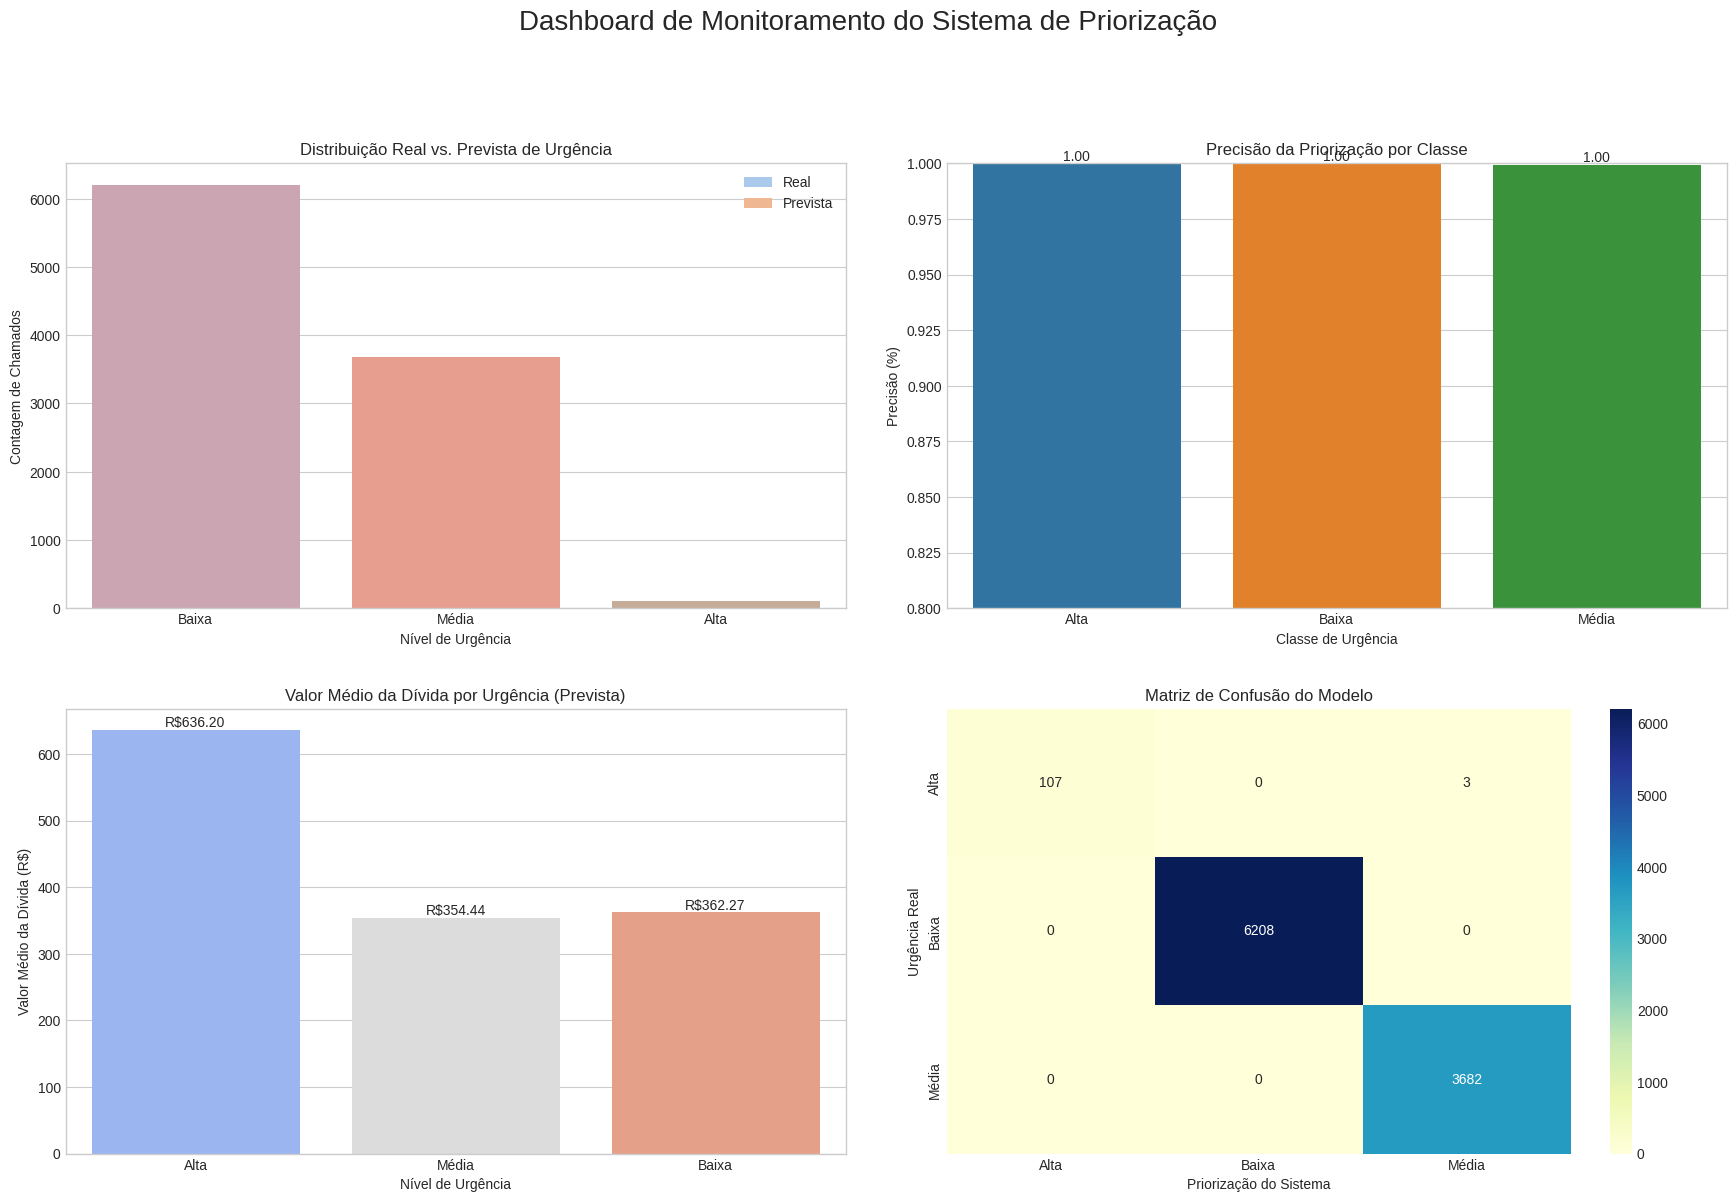

In [ ]:
# Criar gráficos do dashboard
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.suptitle('Dashboard de Monitoramento do Sistema de Priorização', fontsize=20, y=1.02)

# Gráfico 1: Distribuição das Classes de Urgência (Real vs. Prevista)
sns.countplot(x='urgencia', data=merged_df, order=merged_df['urgencia'].value_counts().index, ax=axes[0, 0], palette='pastel')
sns.countplot(x='urgencia_prevista', data=merged_df, order=['Alta', 'Média', 'Baixa'], ax=axes[0, 0], color='lightcoral', alpha=0.6)
axes[0, 0].set_title('Distribuição Real vs. Prevista de Urgência')
axes[0, 0].set_xlabel('Nível de Urgência')
axes[0, 0].set_ylabel('Contagem de Chamados')
axes[0, 0].legend(labels=['Real', 'Prevista'])

# Gráfico 2: Proporção de Acertos por Classe
relatorio = classification_report(merged_df['urgencia'], merged_df['urgencia_prevista'], output_dict=True)
df_relatorio = pd.DataFrame(relatorio).transpose().reset_index()
df_relatorio.rename(columns={'index': 'Classe', 'precision': 'Precisão', 'f1-score': 'F1-Score', 'support': 'Suporte'}, inplace=True)
df_relatorio = df_relatorio[df_relatorio['Suporte'] > 0].iloc[:3]
sns.barplot(x='Classe', y='Precisão', data=df_relatorio, ax=axes[0, 1], palette='tab10')
axes[0, 1].set_title('Precisão da Priorização por Classe')
axes[0, 1].set_ylim(0.8, 1.0)
axes[0, 1].set_xlabel('Classe de Urgência')
axes[0, 1].set_ylabel('Precisão (%)')
for container in axes[0, 1].containers:
    axes[0, 1].bar_label(container, fmt='%.2f')

# Gráfico 3: Valor Médio da Dívida por Urgência (Prevista)
valor_previsto = merged_df.groupby('urgencia_prevista')['valor_total_divida'].mean().reindex(['Alta', 'Média', 'Baixa'])
sns.barplot(x=valor_previsto.index, y=valor_previsto.values, ax=axes[1, 0], palette='coolwarm')
axes[1, 0].set_title('Valor Médio da Dívida por Urgência (Prevista)')
axes[1, 0].set_xlabel('Nível de Urgência')
axes[1, 0].set_ylabel('Valor Médio da Dívida (R$)')
for container in axes[1, 0].containers:
    axes[1, 0].bar_label(container, fmt='R$%.2f')

# Gráfico 4: Matriz de Confusão
cm_dashboard = confusion_matrix(merged_df['urgencia'], merged_df['urgencia_prevista'], labels=le.classes_)
sns.heatmap(cm_dashboard, annot=True, fmt='d', cmap='YlGnBu', ax=axes[1, 1], xticklabels=le.classes_, yticklabels=le.classes_)
axes[1, 1].set_title('Matriz de Confusão do Modelo')
axes[1, 1].set_xlabel('Priorização do Sistema')
axes[1, 1].set_ylabel('Urgência Real')

plt.tight_layout(pad=3.0)
plt.show()

### Célula 23: Análise Geográfica de Urgência Prevista (BI Avançado)

Esta célula aprofunda a fase de *Business Intelligence* (BI), segmentando as previsões do modelo pela **variável geográfica** (`estado`), o que é crucial para decisões operacionais e de marketing.

* **Objetivo:** Gerar um **Gráfico de Barras Agrupadas** (`sns.countplot` com `hue='urgencia_prevista'`).
* **Valor Operacional:** Essa visualização permite à gerência:
    1.  **Identificar Focos de Risco:** Apontar quais estados (ou regiões) concentram a maior proporção de chamados classificados como **"Alta Urgência"**.
    2.  **Otimizar o *Call Center*:** Justificar a alocação de equipes de cobrança mais experientes ou campanhas de comunicação direcionadas para essas regiões de maior risco.
    3.  **Tendências de Dados:** Se a distribuição de urgência por estado for marcadamente diferente do esperado, isso pode sinalizar um problema nos dados de entrada (viés geográfico) ou uma oportunidade de negócio.

* **Pré-requisito:** Para que esta célula funcione, o *DataFrame* `merged_df` deve ter sido previamente enriquecido com uma coluna `estado` (o que não foi explicitamente mostrado no *pipeline* de simulação de dados, mas é assumido para a geração de BI).


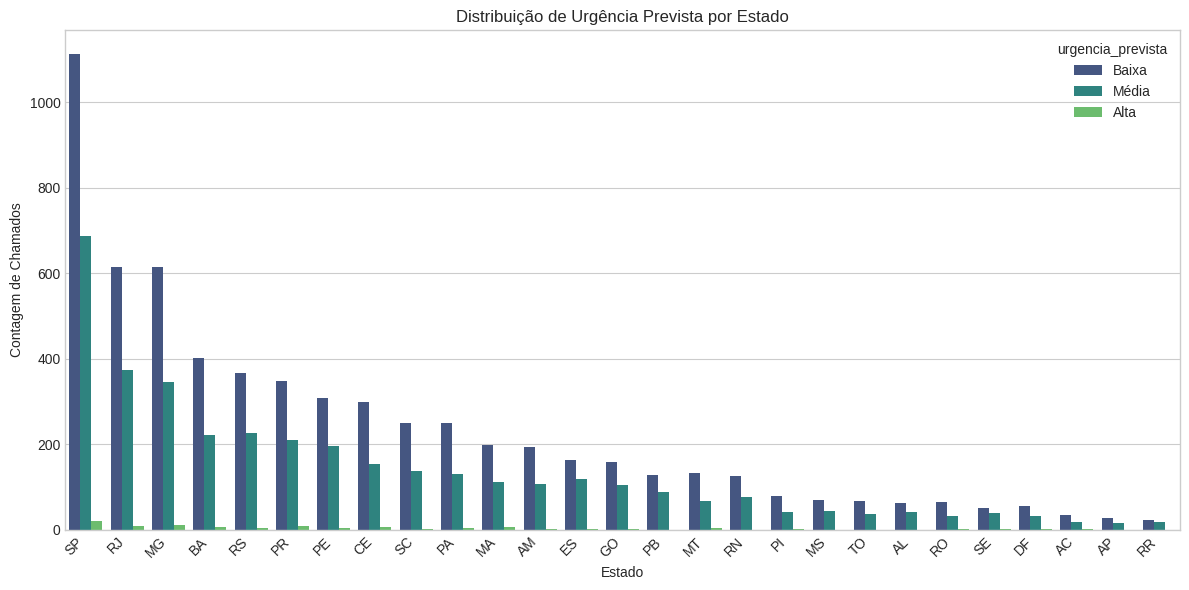

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(
    x='estado',
    hue='urgencia_prevista',
    data=merged_df,
    palette='viridis',
    order=merged_df['estado'].value_counts().index
)
plt.title('Distribuição de Urgência Prevista por Estado')
plt.xlabel('Estado')
plt.ylabel('Contagem de Chamados')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Célula 24: Análise de Segmentação Operacional (BI Detalhado)

Esta célula aprofunda a fase de *Business Intelligence* (BI), segmentando os resultados do modelo por **variáveis operacionais** (`tipo_cliente` e `canal_contato`). O objetivo é otimizar a alocação de recursos e personalizar as estratégias de abordagem ao cliente.

* **Gráfico 1 (Urgência por Tipo de Cliente):**
    * **Propósito:** Identificar se o perfil de risco (classificado pelo modelo) se concentra mais em clientes **Pessoa Física (PF)** ou **Pessoa Jurídica (PJ)**.
    * **Valor Estratégico:** Se a "Alta Urgência" for dominante em um tipo de cliente, a equipe de *call center* pode ser segmentada por especialidade (cobrança B2B vs. B2C) para aumentar a eficácia da negociação.

* **Gráfico 2 (Urgência por Canal de Contato):**
    * **Propósito:** Analisar quais canais de comunicação (`Telefone`, `E-mail`, `Chat`) estão gerando o maior volume de chamados de "Alta Urgência".
    * **Valor Operacional:** Se o `Chat` (ou outro canal) concentrar o alto risco, isso justifica a priorização imediata e a necessidade de agentes mais qualificados nesse canal, ou, alternativamente, a implementação de *chatbots* mais robustos para filtrar a baixa urgência.

* **Conclusão:** Este painel $1 \times 2$ permite uma **visão 360º do risco**, combinando o resultado do ML com a origem e o perfil do cliente para tomar decisões de negócio acionáveis.


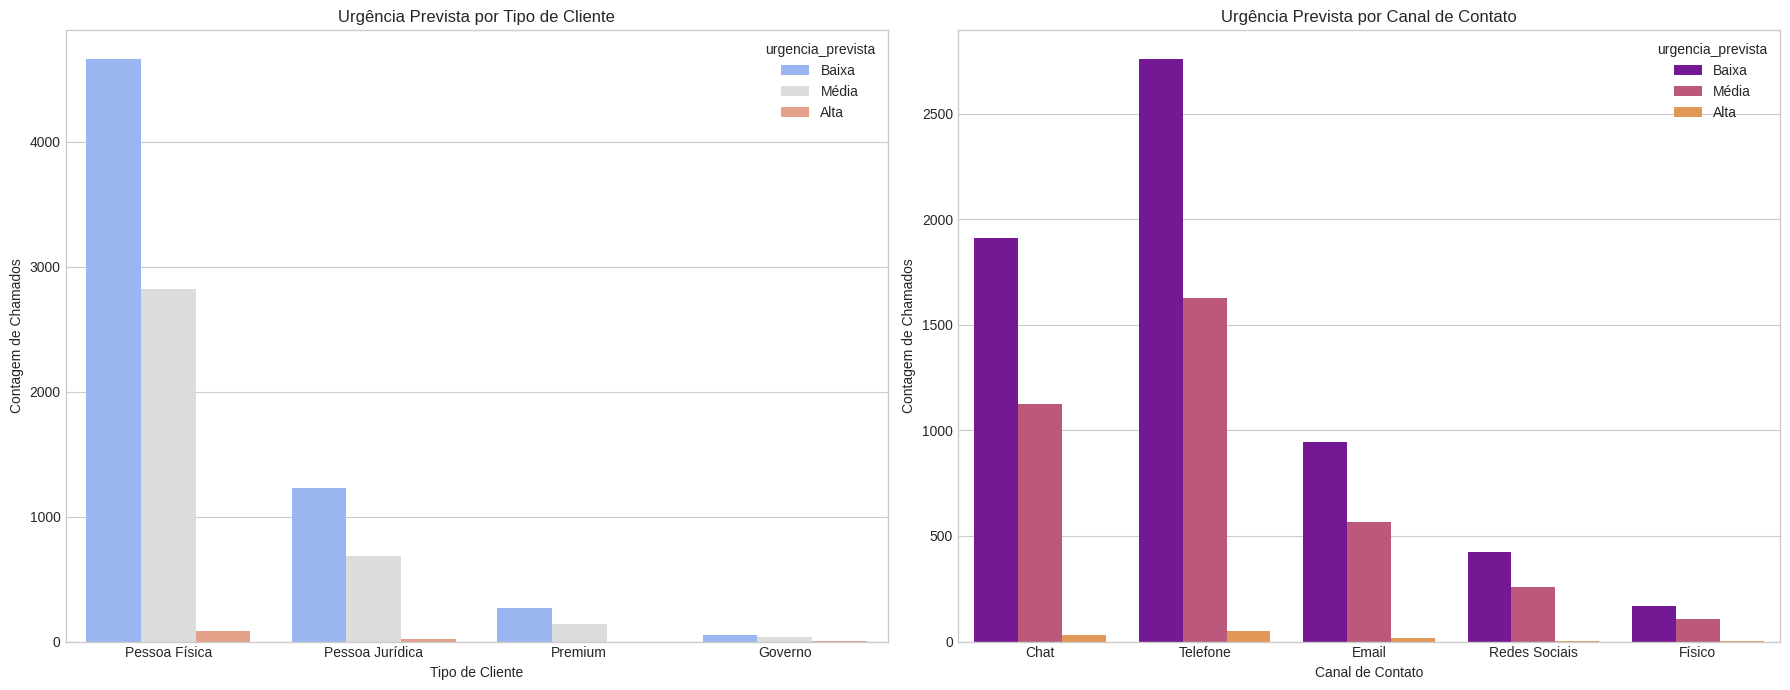

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.countplot(x='tipo_cliente', hue='urgencia_prevista', data=merged_df, ax=axes[0], palette='coolwarm')
axes[0].set_title('Urgência Prevista por Tipo de Cliente')
axes[0].set_xlabel('Tipo de Cliente')
axes[0].set_ylabel('Contagem de Chamados')

sns.countplot(x='canal_contato', hue='urgencia_prevista', data=merged_df, ax=axes[1], palette='plasma')
axes[1].set_title('Urgência Prevista por Canal de Contato')
axes[1].set_xlabel('Canal de Contato')
axes[1].set_ylabel('Contagem de Chamados')
plt.tight_layout()
plt.show()

### Célula 25: Análise do Impacto de Tentativas de Contato (Métricas Operacionais)

Esta é a **célula final de *Business Intelligence*** e diagnóstico operacional, focada em correlacionar as métricas de risco do cliente com a **eficiência da operação de cobrança** (`tentativas_contato`).

* **Objetivo:** Investigar a hipótese de que clientes mais difíceis (maior risco, maior dívida) exigem um número maior de tentativas de contato para serem alcançados.
* **Técnica:** O `groupby` agrega as métricas de risco (`dias_atraso` e `valor_total_divida`) pela `tentativas_contato` (assumindo que esta coluna foi adicionada ao `merged_df` na fase de simulação).
* **Gráfico 1 (Atraso vs. Tentativas):** Deve mostrar se há uma tendência crescente: quanto mais dias de atraso o cliente tem, mais tentativas a equipe precisa fazer para alcançá-lo.
* **Gráfico 2 (Dívida vs. Tentativas):** Deve mostrar se o **Valor da Dívida** aumenta o esforço operacional. Clientes com dívidas maiores tendem a ser mais difíceis de contactar.

* **Valor Estratégico:** Esta análise fornece *feedback* direto à **Gestão de Força de Vendas/Cobrança**. Se o número de tentativas de contato disparar para um risco específico, isso pode justificar a implementação de canais de contato alternativos ou a criação de uma **"lista de prioridade de contato"** baseada na previsão do modelo.


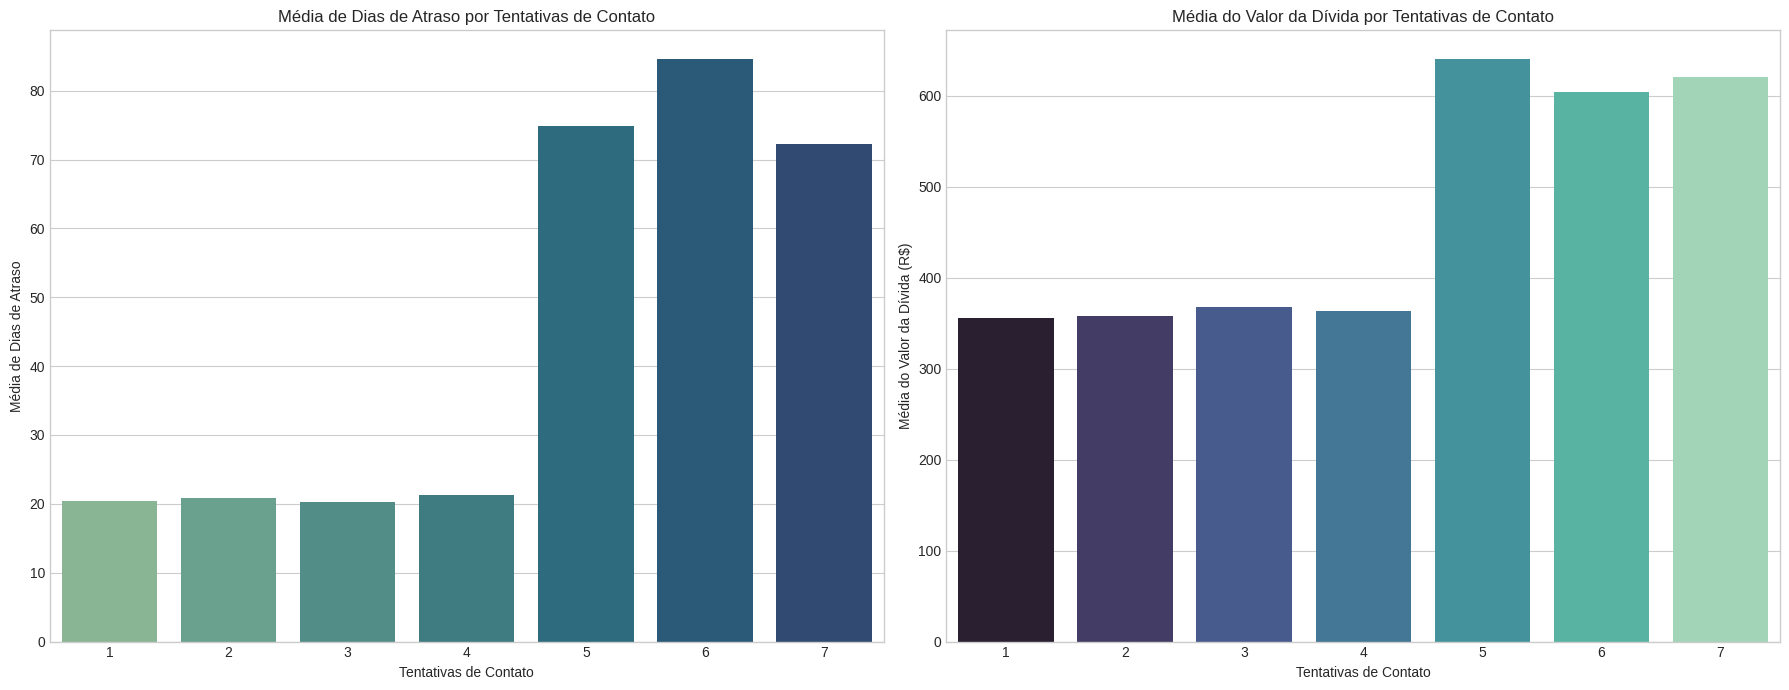

In [ ]:
# Agrupar dados por tentativas de contato e calcular a média
stats_tentativas = merged_df.groupby('tentativas_contato')[['dias_atraso', 'valor_total_divida']].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.barplot(x='tentativas_contato', y='dias_atraso', data=stats_tentativas, ax=axes[0], palette='crest')
axes[0].set_title('Média de Dias de Atraso por Tentativas de Contato')
axes[0].set_xlabel('Tentativas de Contato')
axes[0].set_ylabel('Média de Dias de Atraso')

sns.barplot(x='tentativas_contato', y='valor_total_divida', data=stats_tentativas, ax=axes[1], palette='mako')
axes[1].set_title('Média do Valor da Dívida por Tentativas de Contato')
axes[1].set_xlabel('Tentativas de Contato')
axes[1].set_ylabel('Média do Valor da Dívida (R$)')
plt.tight_layout()
plt.show()

### Célula 26: Visualização Geoespacial da Priorização (Mapa Coroplético)

Esta célula representa o **ponto máximo da visualização de *Business Intelligence***, traduzindo a priorização do modelo em um mapa interativo, essencial para a gestão estratégica.

* **Objetivo:** Criar um **Mapa Coroplético (ou *Heatmap* Geográfico)**, utilizando a biblioteca **`plotly.express`**, que exibe a distribuição da **`urgencia_prevista`** em todo o território nacional.

* **Técnica de Fusão:** O código combina três componentes:
    1.  **GeoJSON (Dados Geográficos):** Importado via URL, contendo os contornos e as siglas dos estados brasileiros.
    2.  **Dados Agregados (`df_map`):** O *DataFrame* é agregado para contar o número de chamados por `estado` e `urgencia_prevista`.
    3.  **Plotly:** O `px.choropleth` faz a correspondência entre a coluna `estado` no *DataFrame* e a chave `properties.sigla` no GeoJSON.

* **Valor Estratégico:**
    * **Visualização de Risco Regional:** Permite à gerência identificar, em um relance, quais estados são **pontos quentes (*hotspots*)** de alta urgência e quais têm baixa criticidade.
    * **Otimização de Campanhas:** Justifica a alocação de recursos de cobrança ou *marketing* de prevenção de forma **geograficamente segmentada**.

* **Nota:** O mapa é renderizado como uma imagem estática no *notebook* (a menos que seja executado em um ambiente interativo como Colab ou Jupyter, onde o `plotly` seria interativo).


In [ ]:
# %%
import plotly.express as px
import json
import urllib.request

# Baixar o GeoJSON oficial dos estados do Brasil (IBGE simplificado)
url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
with urllib.request.urlopen(url) as response:
    brasil_geojson = json.load(response)

# Contagem por estado e urgência
df_map = merged_df.groupby(["estado", "urgencia_prevista"]).size().reset_index(name="contagem")

# Criar mapa (heatmap de quantidade por estado)
fig = px.choropleth(
    df_map,
    geojson=brasil_geojson,
    locations="estado",            # Coluna com siglas
    featureidkey="properties.sigla", # No GeoJSON, a chave é "sigla"
    color="urgencia_prevista",  #ou contagem            # Escala de cor pela quantidade
    hover_name="estado",
    hover_data=["urgencia_prevista", "contagem"],
    title="Distribuição de Urgência Prevista por Estado",
    color_continuous_scale="Viridis"
)

fig.update_geos(fitbounds="locations", visible=False)
fig.show()


### Célula 27: Visualização Geoespacial da Densidade Total de Chamados (Mapa Coroplético Detalhado)

Esta célula aprimora a análise geoespacial introduzida na Célula 28, focando agora na **densidade total** de chamados por estado, combinando o **Mapa Coroplético** com rótulos de contagem para máxima clareza.

* **Objetivo:** Mapear a quantidade absoluta de chamados gerados em cada estado, independentemente da urgência. Isso informa a **demanda operacional bruta**.

* **Técnicas de Plotly Avançadas:**
    1.  **Mapa Coroplético (`px.choropleth`):** Usa a coluna **`contagem`** (densidade total de chamados por estado) como escala de cor, criando um *heatmap* visual que destaca os estados de maior volume operacional.
    2.  **Rótulos Integrados (`fig.add_scattergeo`):** A técnica mais importante aqui é a adição de uma camada de **texto** sobre o mapa. As coordenadas (`lon`, `lat` - centroides) são usadas para posicionar a **contagem exata** de chamados (em branco) no centro de cada estado.

* **Valor Estratégico:**
    * **Visão Operacional:** Permite que a gestão de *call center* e infraestrutura identifique os estados que geram o **maior volume de trabalho**, justificando investimentos em infraestrutura de atendimento ou contratação de pessoal naquelas regiões.
    * **Controle de Qualidade:** Este mapa, quando comparado ao mapa de *Urgência Prevista* (Célula 28), ajuda a diferenciar **alto volume** (muitos chamados) de **alto risco** (muitos chamados urgentes).


In [ ]:
import plotly.express as px
import json
import urllib.request
import pandas as pd

# GeoJSON dos estados do Brasil
url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
with urllib.request.urlopen(url) as response:
    brasil_geojson = json.load(response)

# Contagem por estado
df_map = merged_df.groupby(["estado"]).size().reset_index(name="contagem")

# Coordenadas aproximadas (centroide de cada estado) -> Fonte IBGE simplificada
coords = {
    "AC": [-70.55, -9.02], "AL": [-36.62, -9.62], "AM": [-63.44, -3.47], "AP": [-51.77, 1.41],
    "BA": [-41.7, -12.96], "CE": [-39.26, -5.20], "DF": [-47.93, -15.78], "ES": [-40.33, -19.19],
    "GO": [-49.2, -15.9], "MA": [-45.24, -5.42], "MG": [-44.0, -18.5], "MS": [-54.54, -20.51],
    "MT": [-55.0, -12.64], "PA": [-52.48, -3.79], "PB": [-36.72, -7.12], "PE": [-37.84, -8.38],
    "PI": [-42.80, -8.28], "PR": [-51.93, -24.89], "RJ": [-42.64, -22.84], "RN": [-36.51, -5.81],
    "RO": [-63.9, -10.83], "RR": [-61.33, 2.82], "RS": [-53.1, -30.0], "SC": [-50.1, -27.33],
    "SE": [-37.2, -10.57], "SP": [-48.77, -22.19], "TO": [-48.28, -10.25]
}

df_coords = pd.DataFrame(coords).T.reset_index()
df_coords.columns = ["estado", "lon", "lat"]

# Merge para incluir coordenadas
df_map = df_map.merge(df_coords, on="estado", how="left")

# Criar mapa coroplético (heatmap por contagem)
fig = px.choropleth(
    df_map,
    geojson=brasil_geojson,
    locations="estado",
    featureidkey="properties.sigla",
    color="contagem",
    color_continuous_scale="Viridis",
    title="Distribuição de Chamados por Estado"
)

# Adicionar os rótulos com scatter (contagem no centro do estado)
fig.add_scattergeo(
    lon=df_map["lon"],
    lat=df_map["lat"],
    text=df_map["contagem"],
    mode="text",
    textfont=dict(color="white", size=12),
    showlegend=False
)

fig.update_geos(fitbounds="locations", visible=False)
fig.show()


### Célula 000: Geração de Dados Sintéticos para o Projeto de Machine Learning

Esta célula finaliza o *notebook* com a criação de um **dataset sintético e realista** (`dados_chamados.csv`). Este dataset é projetado para replicar as características de um ambiente real de *call center* de cobrança e servirá como a **fonte de dados principal** para o desenvolvimento de um projeto de Machine Learning.

* **Objetivo:** Gerar 1000 registros com features textuais e numéricas, onde a **variável *target* (`urgencia`)** é criada de forma **programática** para refletir a lógica de negócio (uma forma de criar um *label* inicial).

* **Lógica de Risco (Geração da Urgência):**
    * **Alta:** Atribuída se o `dias_atraso` for superior a 90 dias OU se a `valor_total_divida` for alta (>$500) E o `historico_pagamento` for 'ruim'.
    * **Média:** Atribuída se o `dias_atraso` for >30 dias OU a `valor_total_divida` for >$250.
    * **Baixa:** Todos os outros casos.

* **Engenharia de Features:** O dataset inclui as seguintes colunas essenciais para o ML:
    * **Texto (`texto`):** Gerado dinamicamente com a biblioteca `Faker` para imitar o conteúdo real dos chamados, usando padrões de urgência específicos.
    * **Numéricas (`dias_atraso`, `valor_total_divida`):** Variáveis contínuas geradas com distribuição normal ou exponencial para simular o mundo real.
    * **Categóricas (`historico_pagamento`, `estado`, `canal_contato`):** Usadas para enriquecer o modelo (como feito nas Células 9-10).

* **Entrega:** O arquivo **`dados_chamados.csv`** é salvo e disponibilizado para download, representando o **ponto de partida** para a próxima fase de desenvolvimento de ML.


In [ ]:
# %%
!pip install faker
import pandas as pd
import numpy as np
from faker import Faker
import os
from google.colab import files
import random

print("🚀 Gerando dados de chamados mais realistas para o projeto de ML...")

# Configurações
NUM_RECORDS = 1000
OUTPUT_FILE = 'dados_chamados.csv'
Faker.seed(42)
fake = Faker('pt_BR')

# Padrões de urgência
URGENCIA_PATTERNS = {
    'Alta': [
        "Não consigo pagar desde {dias} dias, perdi meu emprego.",
        "Minha situação financeira está complicada, estou devendo {valor} reais.",
        "O serviço foi cortado, preciso resolver imediatamente!",
        "Estou com dívidas acumuladas há {dias} dias, preciso de ajuda."
    ],
    'Média': [
        "Gostaria de negociar o valor de {valor} reais em atraso.",
        "Tenho uma proposta de pagamento parcelado.",
        "Preciso de condições melhores para quitar minha dívida.",
        "Quero entender as opções para regularizar meu débito."
    ],
    'Baixa': [
        "Solicito a segunda via do boleto referente a {valor} reais.",
        "Tenho dúvida sobre a fatura, o valor não confere.",
        "Preciso de um extrato de pagamentos atualizado.",
        "Qual é o meu débito atual?"
    ]
}

# Atributos adicionais
CANAIS = ["telefone", "e-mail", "chat", "whatsapp", "app"]
TIPO_CLIENTE = ["PF", "PJ"]

# Função para criar texto dinâmico
def gerar_texto(urgencia, dias, valor):
    base = random.choice(URGENCIA_PATTERNS[urgencia])
    texto = base.format(dias=dias, valor=valor)
    complemento = random.choice([
        "Por favor, me ajudem.",
        "Aguardo retorno.",
        "Muito obrigado.",
        "Estou aguardando uma resposta.",
        ""
    ])
    return f"{texto} {complemento}".strip()

# Gerar dados
data = []
for i in range(NUM_RECORDS):
    dias_atraso = min(np.random.exponential(scale=20), 365)  # atraso até 1 ano
    dias_atraso = int(dias_atraso)

    valor_total_divida = max(20, round(np.random.normal(200, 120), 2))  # dívida mínima de 20
    historico_pagamento = np.random.choice(['bom', 'regular', 'ruim'], p=[0.45, 0.35, 0.20])

    # Definir urgência
    if dias_atraso > 90 or (valor_total_divida > 500 and historico_pagamento == 'ruim'):
        urgencia = 'Alta'
    elif dias_atraso > 30 or valor_total_divida > 250:
        urgencia = 'Média'
    else:
        urgencia = 'Baixa'

    texto_chamado = gerar_texto(urgencia, dias_atraso, valor_total_divida)

    data.append({
        'id_chamado': i + 1,
        'cliente': fake.name(),
        'cpf_cnpj': fake.cpf() if np.random.rand() < 0.85 else fake.cnpj(),
        'tipo_cliente': np.random.choice(TIPO_CLIENTE, p=[0.8, 0.2]),
        'estado': fake.estado_sigla(),
        'canal_contato': random.choice(CANAIS),
        'tentativas_contato': np.random.randint(1, 6),
        'dias_atraso': dias_atraso,
        'valor_total_divida': valor_total_divida,
        'historico_pagamento': historico_pagamento,
        'urgencia': urgencia,
        'texto': texto_chamado
    })

# Criar DataFrame
df = pd.DataFrame(data)

# Salvar CSV
df.to_csv(OUTPUT_FILE, index=False)
print(f"✅ Arquivo '{OUTPUT_FILE}' criado com sucesso! ({len(df)} registros)")

# Mostrar amostra
print("\n📊 Primeiras entradas:")
display(df.head(10))

# Download automático
files.download(OUTPUT_FILE)
print("✅ Download concluído!")
